
## Integrantes
*   María Belén Díaz
*   Matías Cifuentes
*   Manuel Adrian
***

# 1 - Introducción

En el siguiente notebook se hará un repaso secuenciado y detallado de toda la programación y análisis asociado a la creación de un modelo de fuga de clientes y a la caracterización de estos, además de recomendaciones comerciales que ayuden a disminuir estas tendencias para un banco ficticio y sus gerentes asociados

## 1.1 Descripción del problema

La primera tarea consiste en desarrollar un modelo predictivo que permita identificar tempranamente cuáles clientes
son más propensos a fugarse. La segunda tarea consiste en definir una serie de políticas comerciales que permitan retener a estos potenciales clientes fugitivos.

## 1.2 Objetivo






Diseñar modelo de aprendizaje automático buscando predecir la variación en la retención futura de clientes proponiendo los lineamientos de acciones comerciales bancarias asociadas a técnicas de aprendizaje no supervisado

### 1.2.1 Objetivo específico

*   Analizar datos en búsqueda de patrones triviales
* Preprocesar el dataset facilitando el trabajo con la información
* Seleccionar mejor modelo de aprendizaje supervisado buscando predecir la fuga de clientes
* Caracterizar y definir acciones comerciales en búsqueda de evitar posibles fugas de clientes

# 2 - Análisis exploratorio del conjunto de datos

Se importan las librerías a usar en el presente notebook

In [ ]:
# manejo de datos
import numpy as np
import pandas as pd

# hay algunos warnings en la sección de "Desbalance de clases", con estas lineas los omitimos
import warnings
warnings.filterwarnings("ignore")

# imputación de datos
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# transformación
from sklearn.preprocessing import MinMaxScaler

# selección de modelos
from sklearn.model_selection import cross_val_score
from sklearn import model_selection 

# métricas
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

#Clusters
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
!pip install KModes
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set(style='white', palette='seismic')
from sklearn.metrics import roc_curve
from plotnine import *
import plotnine

# otras
import collections
from collections import Counter

df_general = pd.read_csv("https://raw.githubusercontent.com/ssantanar/datasets/master/fuga/BASEFUGA_GENERAL.csv", sep=",")
df_validacion = pd.read_csv("https://raw.githubusercontent.com/ssantanar/datasets/master/fuga/BASEFUGA_VALIDACION.csv", sep=";")
df_general.head()


,ID,GENERO,RENTA,EDAD,NIV_EDUC,E_CIVIL,COD_OFI,COD_COM,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
0,1,M,746476,39.0,MED,CAS,68,213.0,LOS ANGELES,0,38292,0,434357,1766,9110,340,2,2000000,NO,NO FUGA
1,2,F,11901,49.0,MED,VIU,16,89.0,SANTIAGO,0,0,0,0,48,0,0,1,7500000,SI,NO FUGA
2,3,M,1651421,39.0,TEC,CAS,90,16.0,ANTOFAGASTA,0,604169,0,0,323,26489,2925,1,8000000,NO,NO FUGA
3,4,F,638969,36.0,UNV,CAS,85,115.0,SANTIAGO,0,5125,0,198998,94,0,105,1,2600000,NO,NO FUGA
4,5,M,860113,44.0,TEC,CAS,45,80.0,SANTIAGO,0,11946,0,73959,149,0,272,1,6400000,NO,NO FUGA


## 2.1 Vista preliminar

In [ ]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            2294 non-null   int64  
 1   GENERO        2283 non-null   object 
 2   RENTA         2294 non-null   int64  
 3   EDAD          2292 non-null   float64
 4   NIV_EDUC      2283 non-null   object 
 5   E_CIVIL       2283 non-null   object 
 6   COD_OFI       2294 non-null   int64  
 7   COD_COM       2291 non-null   float64
 8   CIUDAD        2291 non-null   object 
 9   D_Marzo       2294 non-null   int64  
 10  D_Abril       2294 non-null   int64  
 11  D_Mayo        2294 non-null   int64  
 12  D_Junio       2294 non-null   int64  
 13  D_Julio       2294 non-null   int64  
 14  D_Agosto      2294 non-null   int64  
 15  D_Septiembre  2294 non-null   int64  
 16  M_MOROSO      2294 non-null   int64  
 17  MONTO         2294 non-null   int64  
 18  SEGURO        2294 non-null 

In [ ]:
df_general.isna().sum()

ID               0
GENERO          11
RENTA            0
EDAD             2
NIV_EDUC        11
E_CIVIL         11
COD_OFI          0
COD_COM          3
CIUDAD           3
D_Marzo          0
D_Abril          0
D_Mayo           0
D_Junio          0
D_Julio          0
D_Agosto         0
D_Septiembre     0
M_MOROSO         0
MONTO            0
SEGURO           0
FUGA             0
dtype: int64

**OBS:** Los valores en negrita son atributos que presentan algún valor nulo
1. ID: identificador del cliente
2. ***Genero: Genero del cliente***
3. Renta: Renta en pesos
4. ***Edad: Edad en años***
5. ***NIV_Educ: Nivel educacional***
6. ***E_Civil: Estado civil***
7. COD_Ofi: Código de la oficina
8. ***COD_Com: Código de la comuna***
9. ***Ciudad: Ciudad de la oficina***
10. D_Marzo: Deuda de Marzo
11. D_Abril: Deuda de Abril
12. D_Mayo: Deuda de Mayo
13. D_Junio: Deuda de Junio
14. D_Julio: Deuda de Julio
15. D_Agosto: Deuda de Agosto
16. D_Septiembre: Deuda de Septiembre
17. M_Moroso: Meses en Mora
18. Monto: Monto crédito preaprobado
19. Seguro: Seguro de gravamen
20. Fuga: Variable objetivo

In [ ]:
df_general.describe().round(2)

,ID,RENTA,EDAD,COD_OFI,COD_COM,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO
count,2294.00,2294.00,2292.00,2294.00,2291.00,2294.00,2294.00,2294.00,2294.00,2294.00,2294.00,2294.00,2294.00,2294.00
mean,1147.50,852756.27,43.55,68.54,107.95,153020.64,272681.03,103231.53,189976.06,566.85,3578.76,1940.64,1.25,3477092.41
std,662.37,1379715.21,8.88,40.16,84.77,498187.54,402325.69,870698.44,670504.23,1075.33,8942.38,9868.82,0.75,2292933.05
min,1.00,176.00,-50.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,500000.00
25%,574.25,100381.50,39.00,31.00,80.00,0.00,17674.25,0.00,0.00,7.00,0.00,0.00,1.00,1700000.00
50%,1147.50,369934.50,44.00,56.00,90.00,0.00,134474.50,0.00,5502.00,146.00,0.00,56.00,1.00,2600000.00
75%,1720.75,826758.25,50.00,92.00,118.00,0.00,374425.00,0.00,174906.00,629.75,1486.25,497.25,2.00,4800000.00
max,2294.00,8454317.00,130.00,155.00,516.00,9458161.00,5495534.00,18396961.00,20634612.00,11187.00,88837.00,249652.00,3.00,8000000.00


**OBS**: Exiten algunos outliers evidentes en el anterior análisis tales como edades negativas dentro del dataset. Lo anterior y los otros tipos de datos atípicos será preprocesado en secciones posteriores

## 2.2 Balance de etiquedas en el conjunto de datos

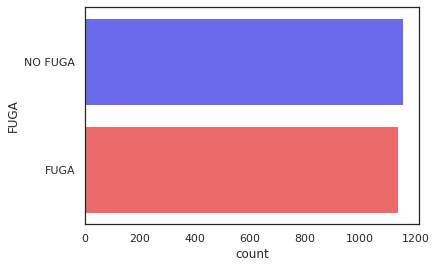

In [ ]:
sns.countplot(y='FUGA', data=df_general, palette='seismic')
#df_general['FUGA'].value_counts()

**OBS:** se puede observar un buen equilibrio entre las clases ( 1157 NO FUGA y 1137 FUGA)

## 2.3 Exploración de variables continuas

Text(0.5, 1.0, 'Histograma D_Septiembre')

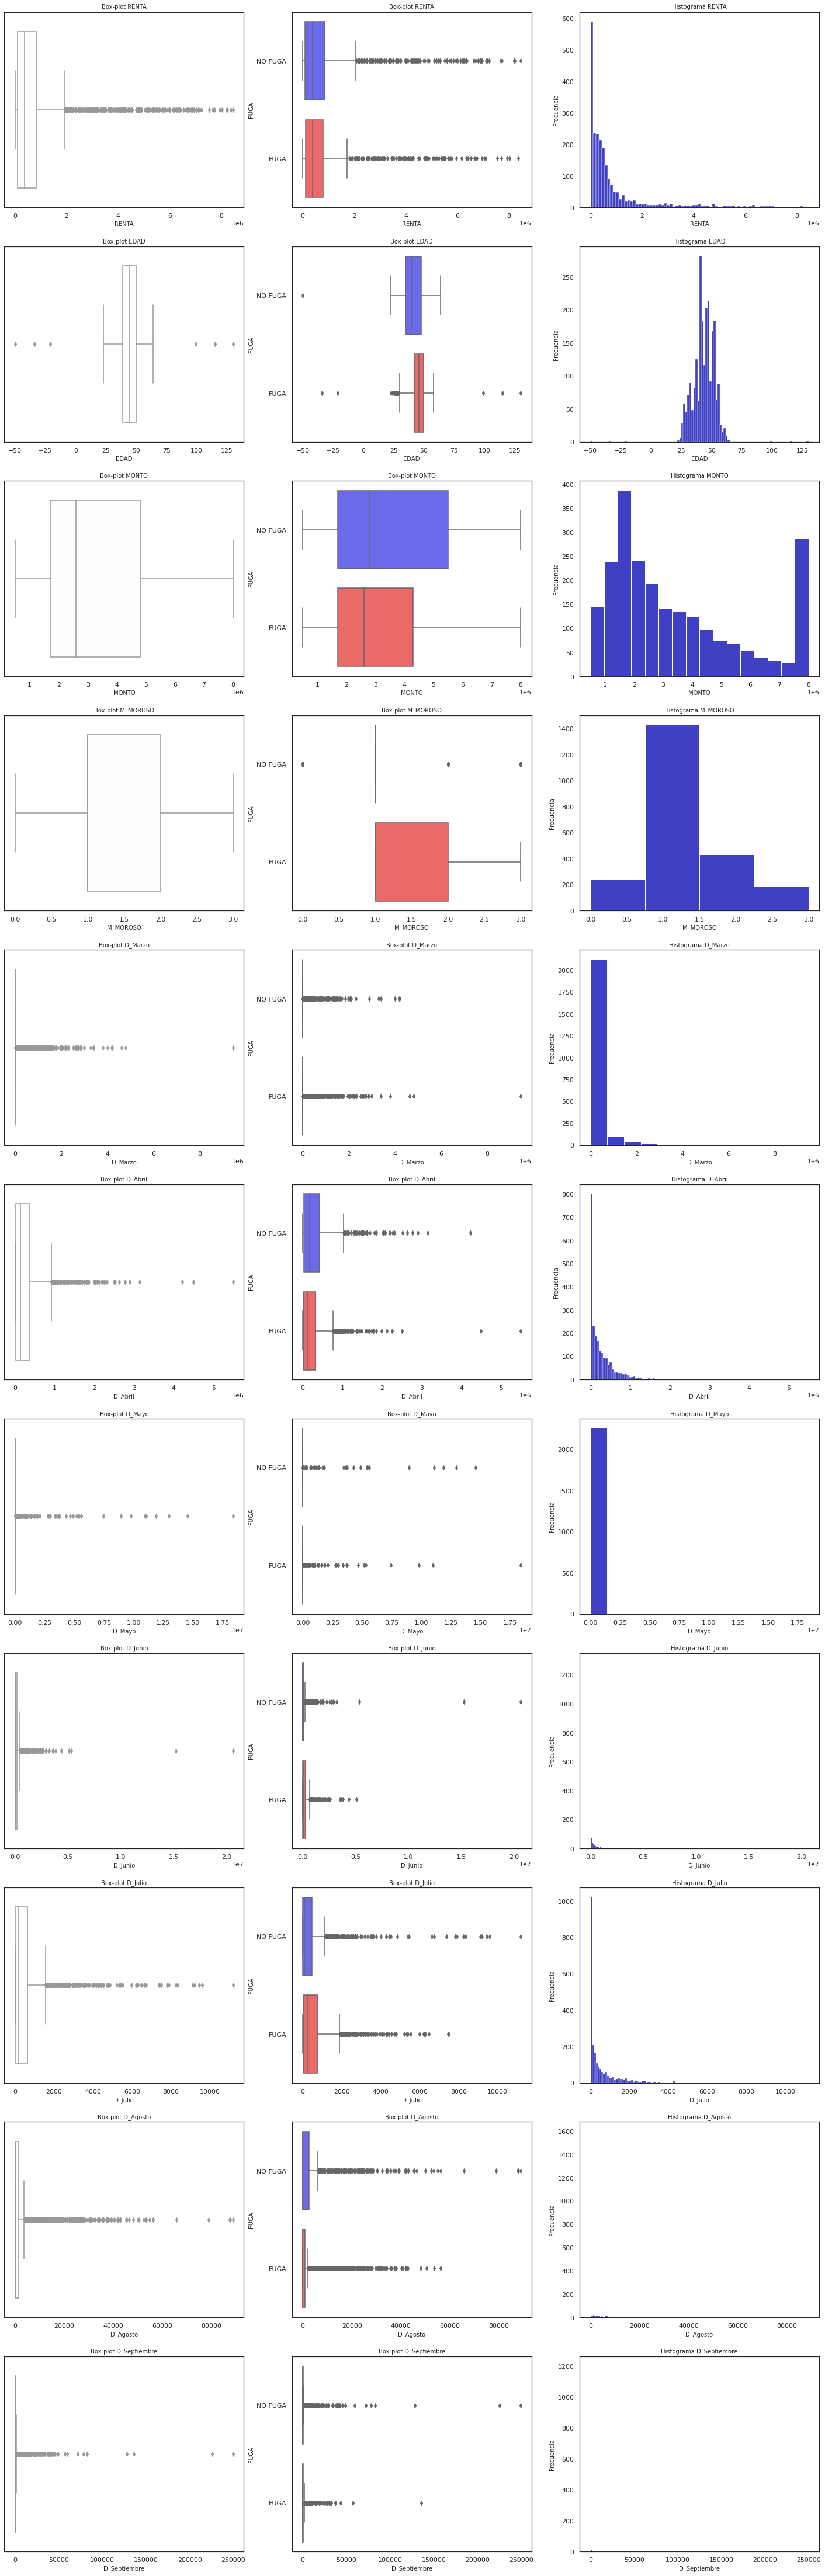

In [ ]:
fig, axes = plt.subplots(11,3,figsize=(25,80))

# gráficos fila 1
a3 = sns.boxplot(x='RENTA', data=df_general, palette='seismic', ax=axes[0,0])
a3.set_xlabel('RENTA',fontsize=10)
a3.set_title('Box-plot RENTA',fontsize=10)

a1 = sns.boxplot(x='RENTA', y='FUGA', data=df_general, palette='seismic', ax=axes[0,1])
a1.set_ylabel('FUGA',fontsize=10)
a1.set_xlabel('RENTA',fontsize=10)
a1.set_title('Box-plot RENTA',fontsize=10)

a2 = sns.histplot(data=df_general, x='RENTA',ax=axes[0,2])
a2.set_ylabel('Frecuencia',fontsize=10)
a2.set_xlabel('RENTA',fontsize=10)
a2.set_title('Histograma RENTA',fontsize=10)

# gráficos fila 2
b3 = sns.boxplot(x='EDAD', data=df_general, palette='seismic', ax=axes[1,0])
b3.set_xlabel('EDAD',fontsize=10)
b3.set_title('Box-plot EDAD',fontsize=10) 
b1 = sns.boxplot(x='EDAD', y='FUGA', data=df_general, palette='seismic', ax=axes[1,1])
b1.set_ylabel('FUGA',fontsize=10)
b1.set_xlabel('EDAD',fontsize=10)
b1.set_title('Box-plot EDAD',fontsize=10)

b2 = sns.histplot(data=df_general, x='EDAD',ax=axes[1,2])
b2.set_ylabel('Frecuencia',fontsize=10)
b2.set_xlabel('EDAD',fontsize=10)
b2.set_title('Histograma EDAD',fontsize=10)

# gráficos fila 3
k3 = sns.boxplot(x='MONTO', data=df_general, palette='seismic', ax=axes[2,0])
k3.set_xlabel('MONTO',fontsize=10)
k3.set_title('Box-plot MONTO',fontsize=10)

k1 = sns.boxplot(x='MONTO', y='FUGA', data=df_general, palette='seismic', ax=axes[2,1])
k1.set_ylabel('FUGA',fontsize=10)
k1.set_xlabel('MONTO',fontsize=10)
k1.set_title('Box-plot MONTO',fontsize=10)

k2 = sns.histplot(data=df_general, x='MONTO',ax=axes[2,2])
k2.set_ylabel('Frecuencia',fontsize=10)
k2.set_xlabel('MONTO',fontsize=10)
k2.set_title('Histograma MONTO',fontsize=10)

# gráficos fila 4
j3 = sns.boxplot(x='M_MOROSO', data=df_general, palette='seismic', ax=axes[3,0])
j3.set_xlabel('M_MOROSO',fontsize=10)
j3.set_title('Box-plot M_MOROSO',fontsize=10)

j1 = sns.boxplot(x='M_MOROSO', y='FUGA', data=df_general, palette='seismic', ax=axes[3,1])
j1.set_ylabel('FUGA',fontsize=10)
j1.set_xlabel('M_MOROSO',fontsize=10)
j1.set_title('Box-plot M_MOROSO',fontsize=10)

j2 = sns.histplot(data=df_general, x='M_MOROSO',ax=axes[3,2], bins = 4)
j2.set_ylabel('Frecuencia',fontsize=10)
j2.set_xlabel('M_MOROSO',fontsize=10)
j2.set_title('Histograma M_MOROSO',fontsize=10)

# gráficos fila 5
c3 = sns.boxplot(x='D_Marzo', data=df_general, palette='seismic', ax=axes[4,0])
c3.set_xlabel('D_Marzo',fontsize=10)
c3.set_title('Box-plot D_Marzo',fontsize=10) 

c1 = sns.boxplot(x='D_Marzo', y='FUGA', data=df_general, palette='seismic', ax=axes[4,1])
c1.set_ylabel('FUGA',fontsize=10)
c1.set_xlabel('D_Marzo',fontsize=10)
c1.set_title('Box-plot D_Marzo',fontsize=10)

c2 = sns.histplot(data=df_general, x='D_Marzo',ax=axes[4,2])
c2.set_ylabel('Frecuencia',fontsize=10)
c2.set_xlabel('D_Marzo',fontsize=10)
c2.set_title('Histograma D_Marzo',fontsize=10)

# gráficos fila 6
d3 = sns.boxplot(x='D_Abril', data=df_general, palette='seismic', ax=axes[5,0])
d3.set_xlabel('D_Abril',fontsize=10)
d3.set_title('Box-plot D_Abril',fontsize=10)

d1 = sns.boxplot(x='D_Abril', y='FUGA', data=df_general, palette='seismic', ax=axes[5,1])
d1.set_ylabel('FUGA',fontsize=10)
d1.set_xlabel('D_Abril',fontsize=10)
d1.set_title('Box-plot D_Abril',fontsize=10)

d2 = sns.histplot(data=df_general, x='D_Abril',ax=axes[5,2])
d2.set_ylabel('Frecuencia',fontsize=10)
d2.set_xlabel('D_Abril',fontsize=10)
d2.set_title('Histograma D_Abril',fontsize=10)

# gráficos fila 7
e3 = sns.boxplot(x='D_Mayo', data=df_general, palette='seismic', ax=axes[6,0])
e3.set_xlabel('D_Mayo',fontsize=10)
e3.set_title('Box-plot D_Mayo',fontsize=10)

e1 = sns.boxplot(x='D_Mayo', y='FUGA', data=df_general, palette='seismic', ax=axes[6,1])
e1.set_ylabel('FUGA',fontsize=10)
e1.set_xlabel('D_Mayo',fontsize=10)
e1.set_title('Box-plot D_Mayo',fontsize=10)

e2 = sns.histplot(data=df_general, x='D_Mayo',ax=axes[6,2])
e2.set_ylabel('Frecuencia',fontsize=10)
e2.set_xlabel('D_Mayo',fontsize=10)
e2.set_title('Histograma D_Mayo',fontsize=10)

# gráficos fila 8
f3 = sns.boxplot(x='D_Junio', data=df_general, palette='seismic', ax=axes[7,0])
f3.set_xlabel('D_Junio',fontsize=10)
f3.set_title('Box-plot D_Junio',fontsize=10)

f1 = sns.boxplot(x='D_Junio', y='FUGA', data=df_general, palette='seismic', ax=axes[7,1])
f1.set_ylabel('FUGA',fontsize=10)
f1.set_xlabel('D_Junio',fontsize=10)
f1.set_title('Box-plot D_Junio',fontsize=10)

f2 = sns.histplot(data=df_general, x='D_Junio',ax=axes[7,2])
f2.set_ylabel('Frecuencia',fontsize=10)
f2.set_xlabel('D_Junio',fontsize=10)
f2.set_title('Histograma D_Junio',fontsize=10)

# gráficos fila 9
g3 = sns.boxplot(x='D_Julio', data=df_general, palette='seismic', ax=axes[8,0])
g3.set_xlabel('D_Julio',fontsize=10)
g3.set_title('Box-plot D_Julio',fontsize=10)

g1 = sns.boxplot(x='D_Julio', y='FUGA', data=df_general, palette='seismic', ax=axes[8,1])
g1.set_ylabel('FUGA',fontsize=10)
g1.set_xlabel('D_Julio',fontsize=10)
g1.set_title('Box-plot D_Julio',fontsize=10)

g2 = sns.histplot(data=df_general, x='D_Julio',ax=axes[8,2])
g2.set_ylabel('Frecuencia',fontsize=10)
g2.set_xlabel('D_Julio',fontsize=10)
g2.set_title('Histograma D_Julio',fontsize=10)

# gráficos fila 10
h3 = sns.boxplot(x='D_Agosto', data=df_general, palette='seismic', ax=axes[9,0])
h3.set_xlabel('D_Agosto',fontsize=10)
h3.set_title('Box-plot D_Agosto',fontsize=10)

h1 = sns.boxplot(x='D_Agosto', y='FUGA', data=df_general, palette='seismic', ax=axes[9,1])
h1.set_ylabel('FUGA',fontsize=10)
h1.set_xlabel('D_Agosto',fontsize=10)
h1.set_title('Box-plot D_Agosto',fontsize=10)

h2 = sns.histplot(data=df_general, x='D_Agosto',ax=axes[9,2])
h2.set_ylabel('Frecuencia',fontsize=10)
h2.set_xlabel('D_Agosto',fontsize=10)
h2.set_title('Histograma D_Agosto',fontsize=10)

# gráficos fila 11
i3 = sns.boxplot(x='D_Septiembre', data=df_general, palette='seismic', ax=axes[10,0])
i3.set_xlabel('D_Septiembre',fontsize=10)
i3.set_title('Box-plot D_Septiembre',fontsize=10)

i1 = sns.boxplot(x='D_Septiembre', y='FUGA', data=df_general, palette='seismic', ax=axes[10,1])
i1.set_ylabel('FUGA',fontsize=10)
i1.set_xlabel('D_Septiembre',fontsize=10)
i1.set_title('Box-plot D_Septiembre',fontsize=10)

i2 = sns.histplot(data=df_general, x='D_Septiembre',ax=axes[10,2])
i2.set_ylabel('Frecuencia',fontsize=10)
i2.set_xlabel('D_Septiembre',fontsize=10)
i2.set_title('Histograma D_Septiembre',fontsize=10)


#la renta de los que se fuga es levemente menor a los que no se fugan.
#la edad de los que se fugan es en promedio mayor a los que no se fugan, pueden ser clientes mas conservadores.

**OBS:** se observa mucha dispersión en los datos, esto se soluciona (en parte) con la aplicación de logaritmo (más adelante)

## 2.4 Exploración de variables categóricas

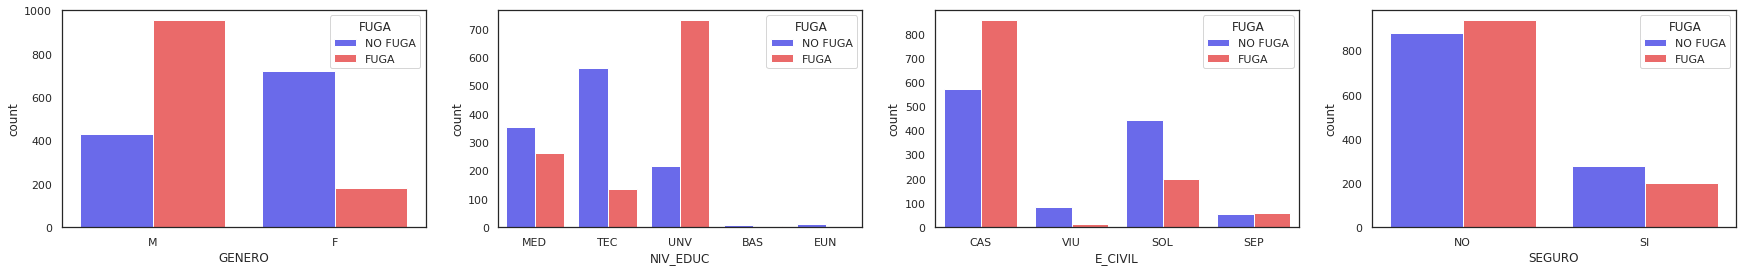

In [ ]:
#fig, axes = plt.subplots(5,1,figsize=(10,60))
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (30,4))

# gráfico columna 1
a2 = sns.countplot(x='GENERO', hue='FUGA', data=df_general,ax=axes[0], palette='seismic')

# gráfico columna 2
b2 = sns.countplot(x='NIV_EDUC', hue='FUGA', data=df_general,ax=axes[1], palette='seismic')

# gráfico columna 3
c2 = sns.countplot(x='E_CIVIL', hue='FUGA', data=df_general,ax=axes[2], palette='seismic')

# gráfico columna 4
e2 = sns.countplot(x='SEGURO', hue='FUGA', data=df_general,ax=axes[3], palette='seismic')

**OBS:** 

1.   Casi un 50% de los hombres fuga
2.   El mayor % de fugados tiene el nivel de escolaridad mas alto (UNV)
3.   Casados tienen el mayor % de fuga
4.   El mayor % de mososos tiene un mes de mora, son rescatables y se puede aplicar alguna política

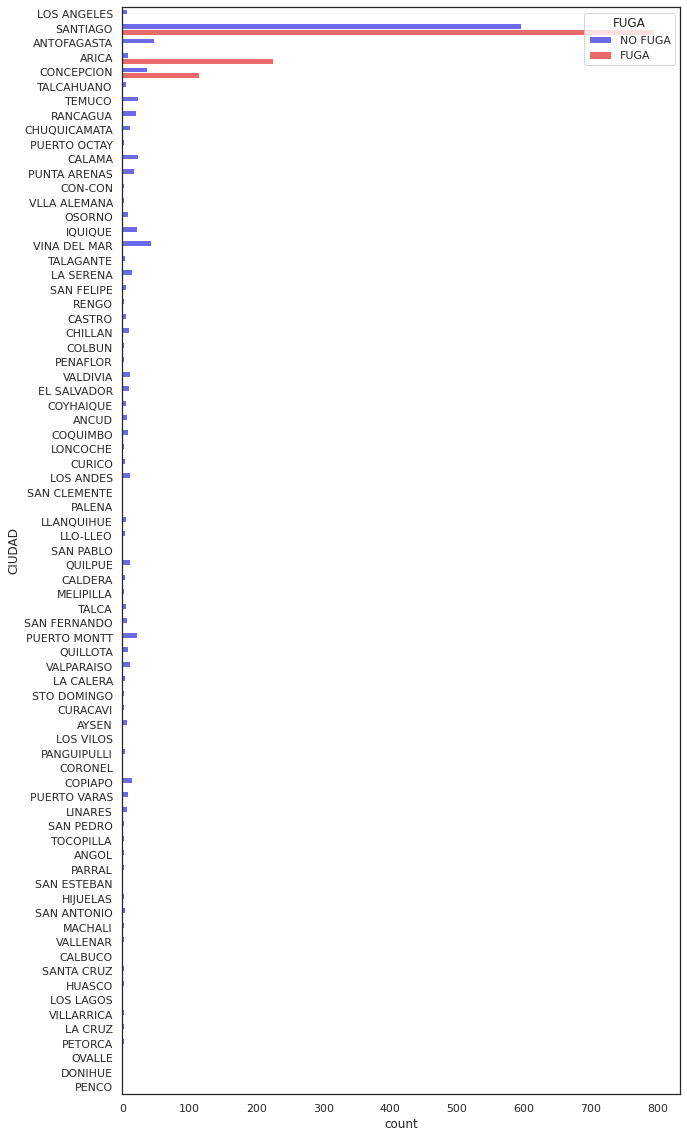

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,20))
sns.countplot(y='CIUDAD', hue='FUGA',data=df_general, palette='seismic')

**OBS:** Se observa que la mayor parte de los clientes fugados pertenecen a Santiago, Concepción y Arica

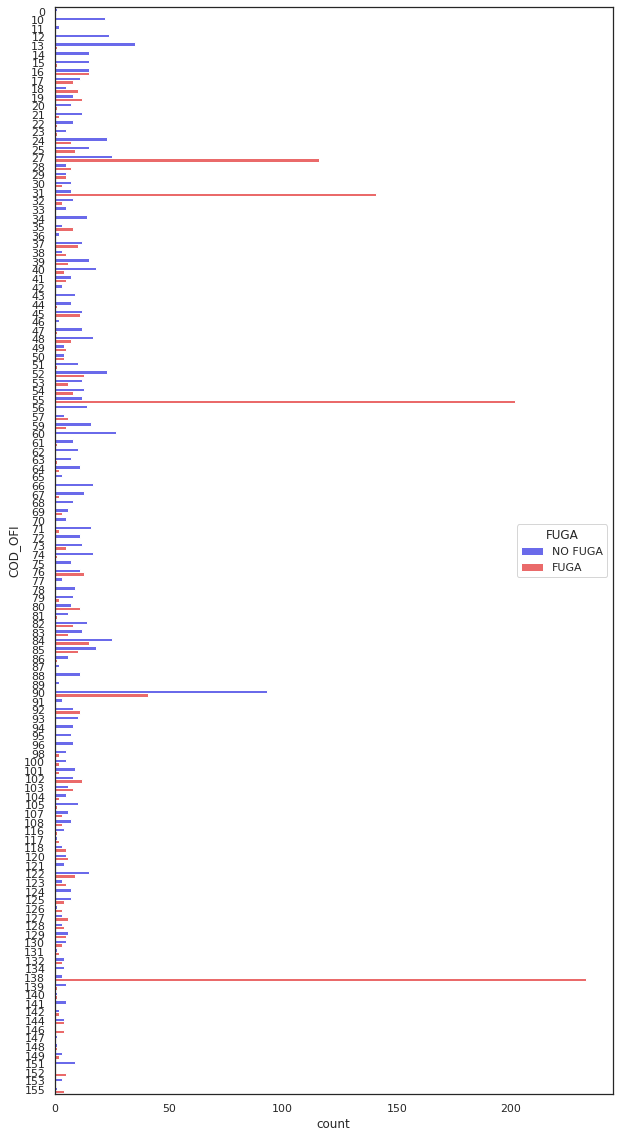

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,20))
sns.countplot(y='COD_OFI', hue='FUGA',data=df_general, palette='seismic')

**OBS:**  Oficina 138 correspondiente a la ciudad de arica tiene el mayor nivel de fuga de las 155. 
Al mirar el gráfico se observa que hay oficinas donde la fuga es mayor o igual a la cantidad de clientes que no se fugan, esto se considerará como un patrón para crear una nueva variable indique si el cliente pertenece a una de estas oficinas "críticas". 




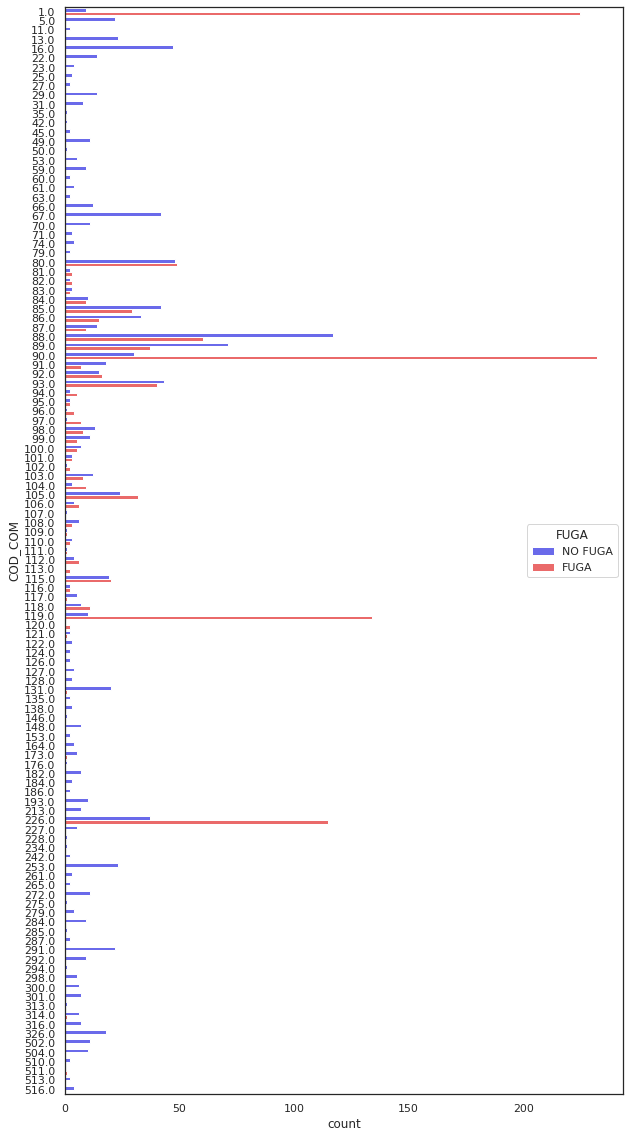

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,20))
sns.countplot(y='COD_COM', hue='FUGA',data=df_general, palette='seismic')

**OBS:** No hay como saber las comunas como para hacer un análisis socioeconomico.
Se aplicará la misma transformación y creación de una variable utilizando la misma idea de las oficinas.

## 2.5 Creación de variables

### 2.5.1 DEUDA_TOTAL

**OBS:** Con el fin de caracterizar mejor al cliente y su comportamiento es que creamos la variable deuda total, que considera la suma de todos los meses disponibles en el set de datos.


In [ ]:
df_general["DEUDA_TOTAL"]= df_general["D_Marzo"] + df_general["D_Abril"] + df_general["D_Mayo"]+df_general["D_Junio"]+df_general["D_Julio"]+df_general["D_Agosto"]+df_general["D_Septiembre"]
#df_general.head()

Text(0.5, 1.0, 'Histograma DEUDA_TOTAL')

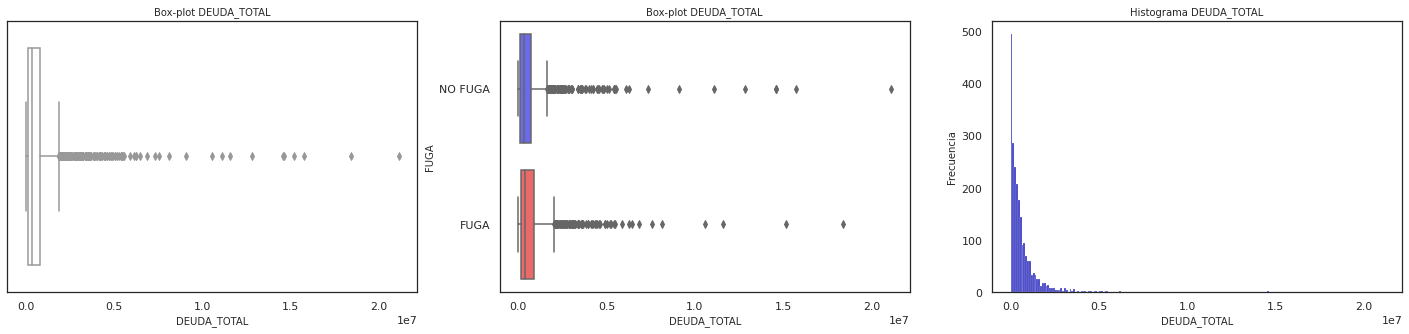

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(25,5))

a1 = sns.boxplot(x='DEUDA_TOTAL', data=df_general, palette='seismic', ax=axes[0])
a1.set_xlabel('DEUDA_TOTAL',fontsize=10)
a1.set_title('Box-plot DEUDA_TOTAL',fontsize=10)

a2 = sns.boxplot(x='DEUDA_TOTAL', y='FUGA', data=df_general, palette='seismic', ax=axes[1])
a2.set_ylabel('FUGA',fontsize=10)
a2.set_xlabel('DEUDA_TOTAL',fontsize=10)
a2.set_title('Box-plot DEUDA_TOTAL',fontsize=10)

a3 = sns.histplot(data=df_general, x='DEUDA_TOTAL',ax=axes[2])
a3.set_ylabel('Frecuencia',fontsize=10)
a3.set_xlabel('DEUDA_TOTAL',fontsize=10)
a3.set_title('Histograma DEUDA_TOTAL',fontsize=10)

### 2.5.2 DEUDA_MESES

**OBS:** Se ha considerado crear este atributo para caracterizar mejor la deuda del cliente y estudiar como puede afectar esta en su decisión de cambiarse de empresa

In [ ]:
# Si un mes tiene deuda se asigna 1, en caso contrario 0 y luego se suman los campos temporales para obtener el número de meses de deuda
df_general["D_Marzo_X"]= df_general.apply(lambda df_general: 1 if df_general["D_Marzo"] > 0 else 0, axis=1)
df_general["D_Abril_X"]= df_general.apply(lambda df_general: 1 if df_general["D_Abril"] > 0 else 0, axis=1)
df_general["D_Mayo_X"]= df_general.apply(lambda df_general: 1 if df_general["D_Mayo"] > 0 else 0, axis=1)
df_general["D_Junio_X"]= df_general.apply(lambda df_general: 1 if df_general["D_Junio"] > 0 else 0, axis=1)
df_general["D_Julio_X"]= df_general.apply(lambda df_general: 1 if df_general["D_Julio"] > 0 else 0, axis=1)
df_general["D_Agosto_X"]= df_general.apply(lambda df_general: 1 if df_general["D_Agosto"] > 0 else 0, axis=1)
df_general["D_Septiembre_X"]=df_general.apply(lambda df_general: 1 if df_general["D_Septiembre"] > 0 else 0, axis=1)
df_general["DEUDA_MESES"]=df_general["D_Marzo_X"]+df_general["D_Abril_X"]+df_general["D_Mayo_X"]+df_general["D_Junio_X"]+df_general["D_Julio_X"]+df_general["D_Julio_X"]+df_general["D_Agosto_X"]+df_general["D_Septiembre_X"]

df_general.drop(['D_Marzo_X','D_Abril_X','D_Mayo_X','D_Junio_X','D_Julio_X','D_Agosto_X','D_Septiembre_X'], axis='columns', inplace=True)

#df_general.head()

Text(0.5, 1.0, 'Histograma DEUDA_MESES')

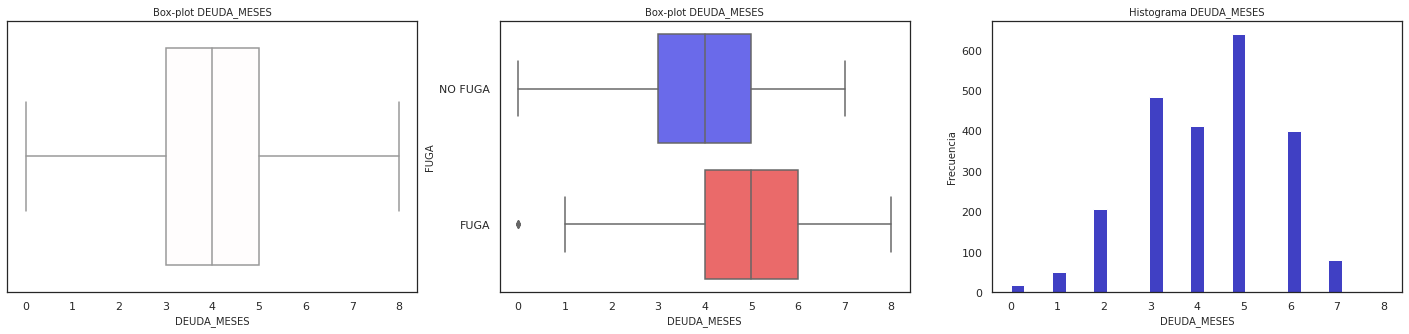

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(25,5))

a1 = sns.boxplot(x='DEUDA_MESES', data=df_general, palette='seismic', ax=axes[0])
a1.set_xlabel('DEUDA_MESES',fontsize=10)
a1.set_title('Box-plot DEUDA_MESES',fontsize=10)

a2 = sns.boxplot(x='DEUDA_MESES', y='FUGA', data=df_general, palette='seismic', ax=axes[1])
a2.set_ylabel('FUGA',fontsize=10)
a2.set_xlabel('DEUDA_MESES',fontsize=10)
a2.set_title('Box-plot DEUDA_MESES',fontsize=10)

a3 = sns.histplot(data=df_general, x='DEUDA_MESES',ax=axes[2])
a3.set_ylabel('Frecuencia',fontsize=10)
a3.set_xlabel('DEUDA_MESES',fontsize=10)
a3.set_title('Histograma DEUDA_MESES',fontsize=10)

**OBS:** se puede ver que la variable creada está balanceada y la distribución de observaciones (frecuencia) es mucho que mejor que otros atributos vistos anteriormente.

## 2.6 Agrupación

### 2.6.1 REGION_METROPOLITANA

**OBS:** Como se pudo apreciar en la visualización de gráfico de barras de la variable, la ciudad de santiago posee cerca del 50% de los datos, esto nos lleva a pensar que una agrupación de las ciudades en región nos permitirá un mejor perfilamiento del cliente

In [ ]:
df_general['REGION_METROPOLITANA'] = df_general['CIUDAD'].apply(lambda x: 'SI' if x=='SANTIAGO' else 'NO')

### 2.6.2 COD_OFI_2

**OBS:** se crea varible cod_ofi_2, donde "sí" indica que el cliente pertenece a una oficina "crítica" y luego se transforma a COD_OFI_FUGA_SI

In [ ]:
tabla_contingencia = pd.crosstab(df_general['COD_OFI'], df_general['FUGA']) 
tabla_contingencia["PORCEN_FUGA"] = tabla_contingencia['FUGA'] / (tabla_contingencia['NO FUGA'] + tabla_contingencia['FUGA'])
tabla_contingencia.drop(['FUGA','NO FUGA'], axis='columns',inplace=True)
tabla_contingencia['COD_OFI_2'] = tabla_contingencia['PORCEN_FUGA'].apply(lambda x: "SI" if x>=0.5 else "NO")
tabla_contingencia.drop(['PORCEN_FUGA'], axis='columns',inplace=True)
df_general = pd.merge(df_general, tabla_contingencia, left_on=['COD_OFI'], right_on=['COD_OFI'], how='left')

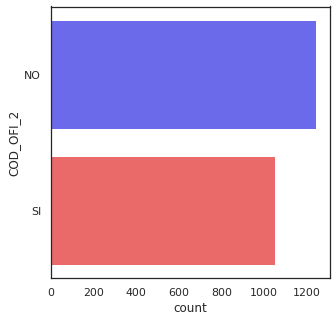

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(y='COD_OFI_2', data=df_general, palette='seismic')

### 2.6.3 COD_COM_2

**OBS:** se crea varible cod_com_2, donde "sí" indica que el cliente pertenece a una comuna "crítica". En ambos casos (oficina y comuna) se puede ver un excelente balance de etiquetas, casi un 50% para cada una.

In [ ]:
tabla_contingencia2 = pd.crosstab(df_general['COD_COM'], df_general['FUGA']) 
tabla_contingencia2["PORCEN_FUGA"] = tabla_contingencia2['FUGA'] / (tabla_contingencia2['NO FUGA'] + tabla_contingencia2['FUGA'])
tabla_contingencia2.drop(['FUGA','NO FUGA'], axis='columns',inplace=True)
tabla_contingencia2['COD_COM_2'] = tabla_contingencia2['PORCEN_FUGA'].apply(lambda x: "SI" if x>=0.5 else "NO")
tabla_contingencia2.drop(['PORCEN_FUGA'], axis='columns',inplace=True)
df_general = pd.merge(df_general, tabla_contingencia2, left_on=['COD_COM'], right_on=['COD_COM'], how='left')

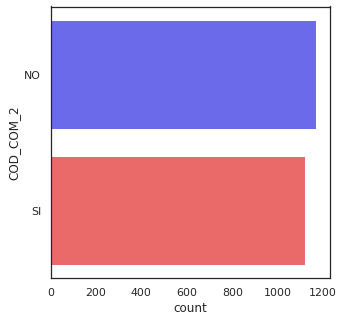

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(y='COD_COM_2', data=df_general, palette='seismic')

### 2.6.4 NIV_EDUC_2

**OBS:** se agrupó los valores de la variable nivel educacional.

In [ ]:
df_general["NIV_EDUC_2"] = df_general.apply(lambda df_general: 'MED'  if df_general["NIV_EDUC"] == 'BAS' else df_general["NIV_EDUC"], axis=1)
df_general["NIV_EDUC_2"] = df_general.apply(lambda df_general: 'UNV'  if df_general["NIV_EDUC_2"] == 'EUN' else df_general["NIV_EDUC_2"], axis=1)

# 3 - Preprocesamiento

## 3.1 Atributos redundantes

**OBS:** se eliminan las variables "redundantes", ya que a partir de los atributos creados se espera obtener similar información.

In [ ]:
df_general.drop(['COD_OFI','COD_COM','CIUDAD','D_Marzo','D_Abril','D_Mayo','D_Junio','D_Julio','D_Agosto','D_Septiembre','NIV_EDUC'], axis='columns', inplace=True)

## 3.2 Declaración de valores perdidos o inconsistentes

In [ ]:
df_general.loc[df_general['EDAD'] < 18, 'EDAD'] = np.nan
df_general.loc[df_general['EDAD'] > 100, 'EDAD'] = np.nan 

## 3.3 Imputación de valores perdidos

In [ ]:
df_general['GENERO'].fillna(df_general['GENERO'].mode()[0], inplace=True)
df_general['NIV_EDUC_2'].fillna(df_general['NIV_EDUC_2'].mode()[0], inplace=True)
df_general['E_CIVIL'].fillna(df_general['E_CIVIL'].mode()[0], inplace=True)
df_general['COD_COM_2'].fillna(df_general['COD_COM_2'].mode()[0], inplace=True)
df_general['EDAD'].fillna(np.nanmedian(df_general['EDAD']), inplace=True)
df_general.isna().sum()

ID                      0
GENERO                  0
RENTA                   0
EDAD                    0
E_CIVIL                 0
M_MOROSO                0
MONTO                   0
SEGURO                  0
FUGA                    0
DEUDA_TOTAL             0
DEUDA_MESES             0
REGION_METROPOLITANA    0
COD_OFI_2               0
COD_COM_2               0
NIV_EDUC_2              0
dtype: int64

# 4 - Transformación

## 4.1 Transformación con logaritmo

In [ ]:
df_general['LOG_RENTA'] = np.log(df_general['RENTA']+1) 
df_general['LOG_EDAD'] = np.log(df_general['EDAD']+1) 
df_general['LOG_M_MOROSO'] = np.log(df_general['M_MOROSO']+1)
df_general['LOG_MONTO'] = np.log(df_general['MONTO']+1)
df_general['LOG_DEUDA_TOTAL'] = np.log(df_general['DEUDA_TOTAL']+1)
df_general['LOG_DEUDA_MESES'] = np.log(df_general['DEUDA_MESES']+1)

df_general.drop(['RENTA','EDAD','M_MOROSO','MONTO','DEUDA_TOTAL','DEUDA_MESES'], inplace=True, axis='columns')

## 4.2 Transformación de variables categóricas

In [ ]:
# obtenemos dummies y concatenamos
df_general.replace({'GENERO':{'F':'GENERO_F','M':'GENERO_M'}}, inplace=True)
df_general.replace({'SEGURO':{'SI':'SEGURO_SI','NO':'SEGURO_NO'}}, inplace=True)
df_general.replace({'REGION_METROPOLITANA':{'SI':'RM_SI','NO':'RM_NO'}}, inplace=True)
df_general.replace({'NIV_EDUC_2':{'MED':1,'TEC':2,'UNV':3}}, inplace=True)
df_general.replace({'E_CIVIL':{'SOL':0,'CAS':1,'SEP':2,'VIU':3}},inplace=True)
df_general.replace({'COD_OFI_2':{'SI':'COD_OFI_FUGA_SI','NO':'COD_OFI_FUGA_NO'}}, inplace=True)
df_general.replace({'COD_COM_2':{'SI':'COD_COM_FUGA_SI','NO':'COD_COM_FUGA_NO'}}, inplace=True)

df_general = pd.concat([df_general, pd.get_dummies(df_general['GENERO'])], axis='columns')
df_general = pd.concat([df_general, pd.get_dummies(df_general['SEGURO'])], axis='columns')
df_general = pd.concat([df_general, pd.get_dummies(df_general['REGION_METROPOLITANA'])], axis='columns')
df_general = pd.concat([df_general, pd.get_dummies(df_general['COD_COM_2'])], axis='columns')
df_general = pd.concat([df_general, pd.get_dummies(df_general['COD_OFI_2'])], axis='columns')


# se elimina variable original y redundantes
df_general.drop(['GENERO','GENERO_F','SEGURO','SEGURO_NO','REGION_METROPOLITANA','RM_NO','COD_OFI_2','COD_OFI_FUGA_NO','COD_COM_2','COD_COM_FUGA_NO'], inplace=True, axis='columns')

## 4.3 Normalización de los datos

In [ ]:
scaler = MinMaxScaler()
df_general[['LOG_RENTA', 'LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL','LOG_DEUDA_MESES','NIV_EDUC_2','E_CIVIL']] = scaler.fit_transform(df_general[['LOG_RENTA', 'LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL','LOG_DEUDA_MESES','NIV_EDUC_2','E_CIVIL']])
df_general.describe().round(1)
df_general

,ID,E_CIVIL,FUGA,NIV_EDUC_2,LOG_RENTA,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,LOG_DEUDA_MESES,GENERO_M,SEGURO_SI,RM_SI,COD_COM_FUGA_SI,COD_OFI_FUGA_SI
0,1,0.333333,NO FUGA,0.0,0.774730,0.357943,0.792481,0.500000,0.776091,0.885622,1,0,0,0,0
1,2,1.000000,NO FUGA,0.0,0.390597,0.514302,0.500000,0.976723,0.230749,0.500000,0,1,1,0,1
2,3,0.333333,NO FUGA,0.5,0.848428,0.357943,0.500000,1.000000,0.792105,0.815465,1,0,0,0,0
3,4,0.333333,NO FUGA,1.0,0.760296,0.303314,0.500000,0.594628,0.724976,0.815465,0,0,1,1,0
4,5,0.333333,NO FUGA,0.5,0.787882,0.440475,0.500000,0.919518,0.673893,0.815465,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,2290,0.000000,NO FUGA,0.5,0.654798,0.424728,1.000000,0.284376,0.793682,0.885622,0,1,1,0,0
2290,2291,0.000000,FUGA,0.5,0.555492,0.581087,0.500000,0.461999,0.833331,0.815465,1,0,0,1,1
2291,2292,0.000000,FUGA,1.0,0.772133,0.541785,0.500000,0.767597,0.800546,0.630930,1,0,0,1,1
2292,2293,0.333333,FUGA,1.0,0.931344,0.408619,0.792481,0.800408,0.795010,0.885622,1,0,1,1,1


# 5 - Selección de atributos

In [ ]:
#Para variables categóricas consideraremos el test CHI-SQUARE
#Para variables númericas consideraremos KS
def ecdf(data):
    # Computa la distribución empirica acumulada (ECDF por sus siglas en ingles)
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x,y

def plot_kolmogorov(sample1, sample2, alpha=0.05):
  import matplotlib.pyplot as plt
  from scipy import stats
  # obtenemos la ECDF para cada muestra y las ordenamos
  x1,y1 = ecdf(sample1)
  x2,y2 = ecdf(sample2)
  # plot
  plt.figure(figsize=(9, 6))
  sns.lineplot(x=x1, y=y1, color='red')
  sns.lineplot(x=x2, y=y2, color='blue')
  # test
  stat, p_val = stats.ks_2samp(sample1, sample2)
  # interpretamos el p-value 
  print(f"p-value: {round(p_val,4)} | alpha: {alpha}") 
  if p_val <= alpha: 
      print('Las distribuciones son independientes (Rechaza Hipótesis Nula)') 
  else: 
      print('Las distribuciones son dependientes (Acepta Hipótesis Nula)') 
  plt.ylabel("Cumulative Distribution Function")
  plt.xlabel('x')
  plt.show()

## 5.1 Variables numéricas

### 5.1.1 LOG_RENTA

p-value: 0.2976 | alpha: 0.05
Las distribuciones son dependientes (Acepta Hipótesis Nula)


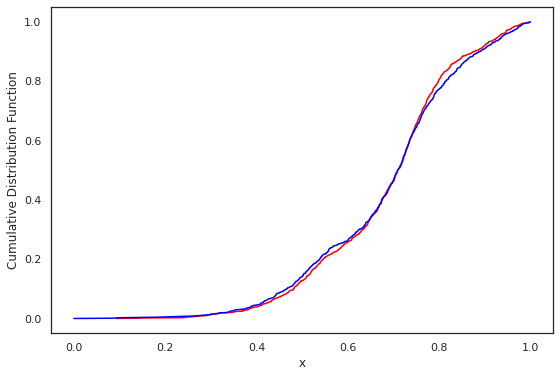

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_RENTA'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_RENTA'].values)

In [ ]:
df_general.drop(['LOG_RENTA'], axis='columns', inplace=True)

### 5.1.2 LOG_EDAD

p-value: 0.0 | alpha: 0.05
Las distribuciones son independientes (Rechaza Hipótesis Nula)


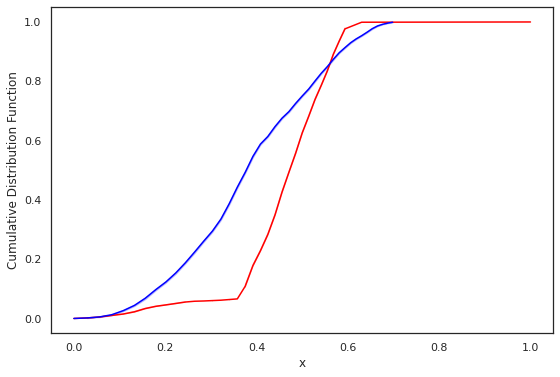

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_EDAD'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_EDAD'].values)

### 5.1.3 LOG_M_MOROSO

p-value: 0.0 | alpha: 0.05
Las distribuciones son independientes (Rechaza Hipótesis Nula)


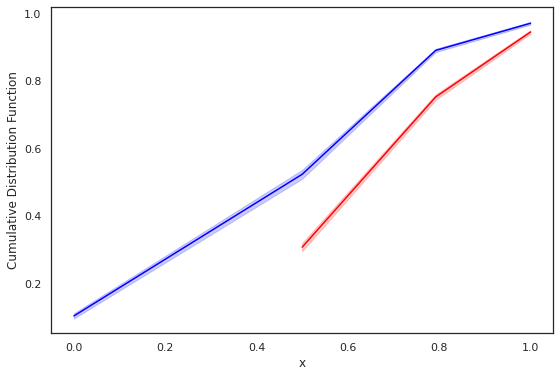

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_M_MOROSO'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_M_MOROSO'].values)

### 5.1.4 LOG_MONTO

p-value: 0.0 | alpha: 0.05
Las distribuciones son independientes (Rechaza Hipótesis Nula)


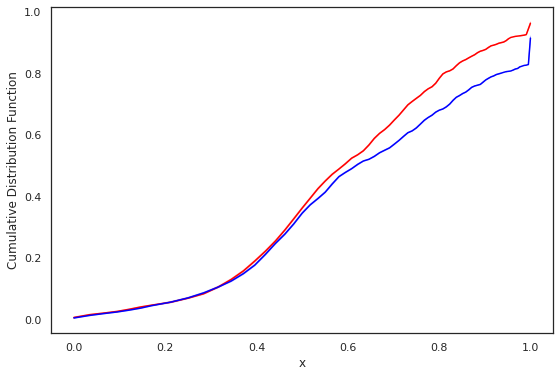

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_MONTO'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_MONTO'].values)

### 5.1.5 LOG_M_MOROSO


p-value: 0.0 | alpha: 0.05
Las distribuciones son independientes (Rechaza Hipótesis Nula)


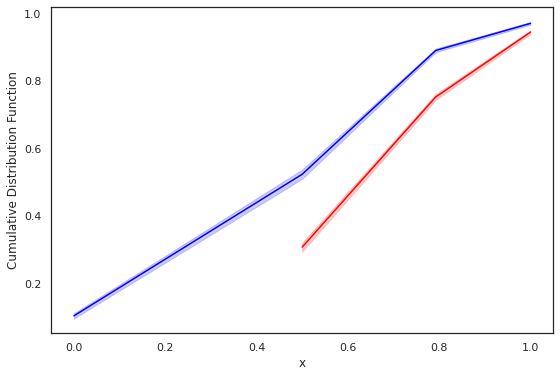

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_M_MOROSO'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_M_MOROSO'].values)

### 5.1.6 LOG_DEUDA_TOTAL


p-value: 0.0 | alpha: 0.05
Las distribuciones son independientes (Rechaza Hipótesis Nula)


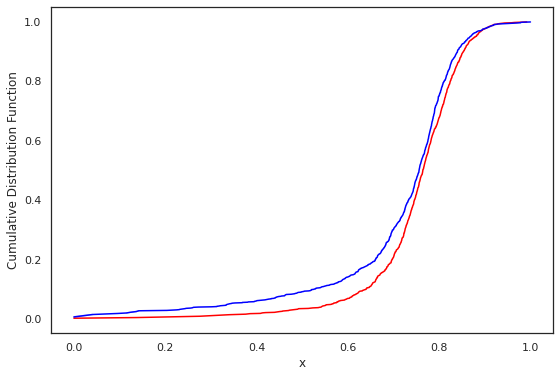

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_DEUDA_TOTAL'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_DEUDA_TOTAL'].values)

### 5.1.7 LOG_DEUDA_MESES


p-value: 0.0 | alpha: 0.05
Las distribuciones son independientes (Rechaza Hipótesis Nula)


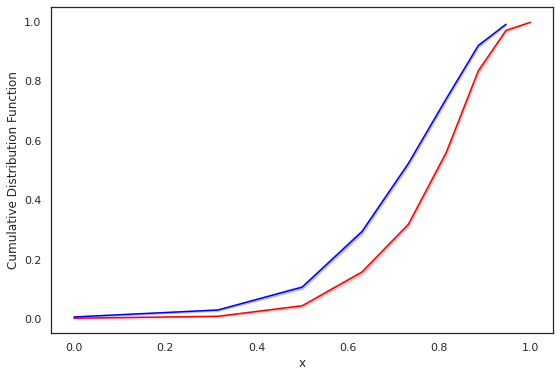

In [ ]:
plot_kolmogorov(df_general[df_general['FUGA']=="FUGA"]['LOG_DEUDA_MESES'].values, df_general[df_general['FUGA']=="NO FUGA"]['LOG_DEUDA_MESES'].values)

**OBS:** se puede ver que las distribuciones de LOG_RENTA son dependientes (Acepta Hipótesis Nula) y por este motivo no se utilizará en la predicción de clases

## 5.2 Variables categóricas

In [ ]:
def chi2(c_table):
  from scipy.stats import chi2_contingency 
# aplicamos el test
  stat, p_val, dof, expected = chi2_contingency(c_table) 
  
# interpretamos el p-value
  alpha = 0.05
  print(f"p-value = {round(p_val,4)}") 
  if p_val <= alpha:
    print('Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas') 
  else: 
    print('Las variables son dependientes (Rechaza Hipótesis Nula) | Existe relación entre ellas') 
  plt.show()  

### 5.2.1 NIV_EDUC_2

In [ ]:
c_table = pd.crosstab(df_general['NIV_EDUC_2'],df_general['FUGA'],margins = False)
print(c_table)

FUGA        FUGA  NO FUGA
NIV_EDUC_2               
0.0          265      361
0.5          136      562
1.0          736      234


In [ ]:
chi2(pd.crosstab(df_general['NIV_EDUC_2'],df_general['FUGA'],margins = False))

p-value = 0.0
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


### 5.2.2 E_CIVIL

In [ ]:
c_table = pd.crosstab(df_general['E_CIVIL'],df_general['FUGA'],margins = False)
print(c_table)

FUGA      FUGA  NO FUGA
E_CIVIL                
0.000000   200      442
0.333333   863      577
0.666667    61       53
1.000000    13       85


In [ ]:
chi2(pd.crosstab(df_general['E_CIVIL'],df_general['FUGA'],margins = False))

p-value = 0.0
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


### 5.2.3 GENERO_M

In [ ]:
c_table = pd.crosstab(df_general['GENERO_M'],df_general['FUGA'],margins = False)
print(c_table)

FUGA      FUGA  NO FUGA
GENERO_M               
0          179      719
1          958      438


In [ ]:
chi2(pd.crosstab(df_general['GENERO_M'],df_general['FUGA'],margins = False))

p-value = 0.0
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


### 5.2.4  SEGURO_SI

In [ ]:
c_table = pd.crosstab(df_general['SEGURO_SI'],df_general['FUGA'],margins = False)
print(c_table)

FUGA       FUGA  NO FUGA
SEGURO_SI               
0           938      878
1           199      279


In [ ]:
chi2(pd.crosstab(df_general['SEGURO_SI'],df_general['FUGA'],margins = False)) 

p-value = 0.0001
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


### 5.2.5  RM_SI

In [ ]:
c_table = pd.crosstab(df_general['RM_SI'],df_general['FUGA'],margins = False)
print(c_table)

FUGA   FUGA  NO FUGA
RM_SI               
0       343      562
1       794      595


In [ ]:
chi2(pd.crosstab(df_general['RM_SI'],df_general['FUGA'],margins = False)) 

p-value = 0.0
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


### 5.2.12 COD_OFI_FUGA_SI

In [ ]:
c_table = pd.crosstab(df_general['COD_OFI_FUGA_SI'],df_general['FUGA'],margins = False)
print(c_table)

FUGA             FUGA  NO FUGA
COD_OFI_FUGA_SI               
0                 259      985
1                 878      172


In [ ]:
chi2(pd.crosstab(df_general['COD_OFI_FUGA_SI'],df_general['FUGA'],margins = False))

p-value = 0.0
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


### 5.2.13 COD_COM_FUGA_SI

In [ ]:
c_table = pd.crosstab(df_general['COD_COM_FUGA_SI'],df_general['FUGA'],margins = False)
print(c_table)

FUGA             FUGA  NO FUGA
COD_COM_FUGA_SI               
0                 244      929
1                 893      228


In [ ]:
chi2(pd.crosstab(df_general['COD_COM_FUGA_SI'],df_general['FUGA'],margins = False))

p-value = 0.0
Las variables son independientes (Acepta Hipótesis Nula) | No existe relación entre ellas


**OBS:** se puede ver que todas las variables son independientes y por este motivo no se va a eliminar ninguna para la predicción

## 5.3 Filtro de dispersión

In [ ]:
df_general.std().round(2)

ID                 662.37
E_CIVIL              0.23
NIV_EDUC_2           0.41
LOG_EDAD             0.13
LOG_M_MOROSO         0.25
LOG_MONTO            0.25
LOG_DEUDA_TOTAL      0.14
LOG_DEUDA_MESES      0.15
GENERO_M             0.49
SEGURO_SI            0.41
RM_SI                0.49
COD_COM_FUGA_SI      0.50
COD_OFI_FUGA_SI      0.50
dtype: float64

## 5.4 Filtro de correlación

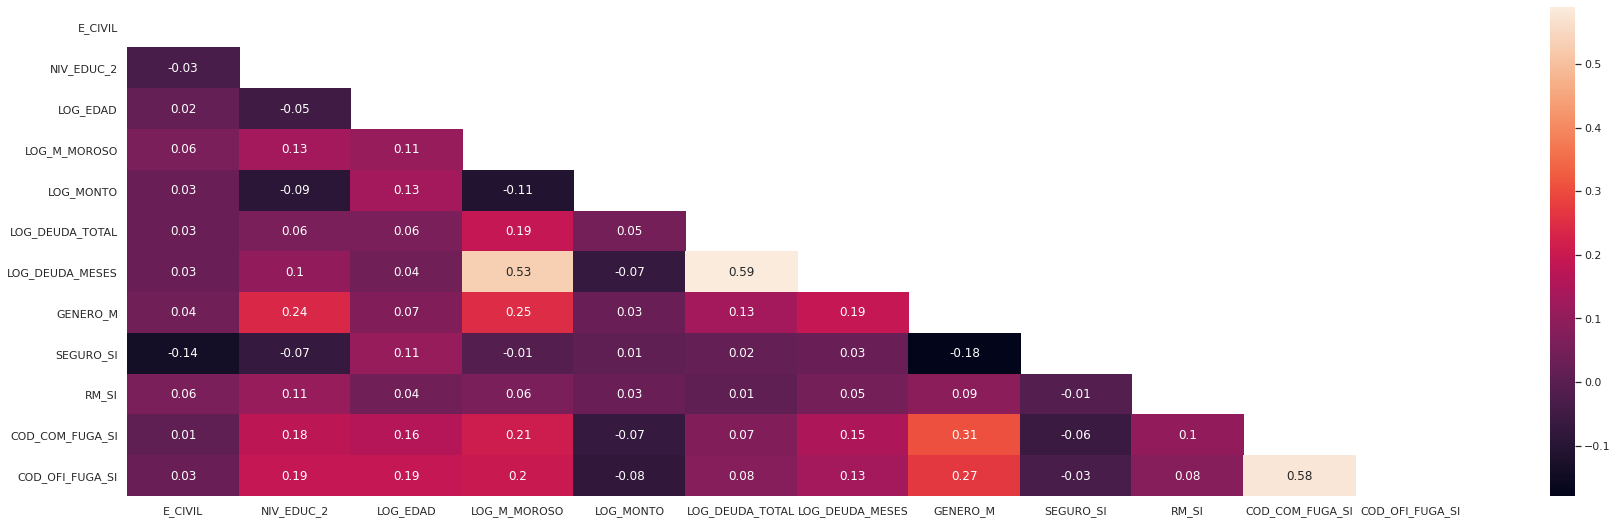

In [ ]:
df_general.drop(['ID'], axis='columns', inplace=True)

plt.figure(figsize=(30,9))
# computamos matriz de correlación
corr_matrix = df_general.corr().round(2)
# esto nos permite graficar sólo la parte superior o inferior de la matriz
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# plot
sns.heatmap(corr_matrix,mask=mask,annot=True)

**OBS:** se observa una alta correlación en algunos atributos, por tal motivo se eliminarán las variables: E_CIVIL, COD_COM_FUGA_SI, LOG_DEUDA_MESES

In [ ]:
df_general.drop(['E_CIVIL','COD_COM_FUGA_SI','LOG_DEUDA_MESES'], axis='columns', inplace=True)
#df_general.drop(['E_CIVIL','LOG_DEUDA_MESES'], axis='columns', inplace=True)
df_general

,FUGA,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI
0,NO FUGA,0.0,0.357943,0.792481,0.500000,0.776091,1,0,0,0
1,NO FUGA,0.0,0.514302,0.500000,0.976723,0.230749,0,1,1,1
2,NO FUGA,0.5,0.357943,0.500000,1.000000,0.792105,1,0,0,0
3,NO FUGA,1.0,0.303314,0.500000,0.594628,0.724976,0,0,1,0
4,NO FUGA,0.5,0.440475,0.500000,0.919518,0.673893,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2289,NO FUGA,0.5,0.424728,1.000000,0.284376,0.793682,0,1,1,0
2290,FUGA,0.5,0.581087,0.500000,0.461999,0.833331,1,0,0,1
2291,FUGA,1.0,0.541785,0.500000,0.767597,0.800546,1,0,0,1
2292,FUGA,1.0,0.408619,0.792481,0.800408,0.795010,1,0,1,1


# 6 - División del dataset

In [ ]:
df_general.replace({'FUGA':{'FUGA':"SI",'NO FUGA':"NO"}}, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_general[df_general.columns.difference(['FUGA'])], df_general['FUGA'], test_size=0.33, random_state=99)
X_train.head()

,COD_OFI_FUGA_SI,GENERO_M,LOG_DEUDA_TOTAL,LOG_EDAD,LOG_MONTO,LOG_M_MOROSO,NIV_EDUC_2,RM_SI,SEGURO_SI
1503,0,0,0.680988,0.357943,0.721881,0.500000,0.0,1,1
1927,1,1,0.729664,0.392130,0.534376,0.792481,0.0,1,0
1502,1,1,0.789318,0.514302,0.711999,0.500000,1.0,1,0
2099,0,0,0.744284,0.581087,0.731500,0.500000,0.0,1,0
1312,1,1,0.680995,0.485698,0.419518,0.500000,0.0,0,0


# 7 - Entrenamiento

## 7.1 KNN

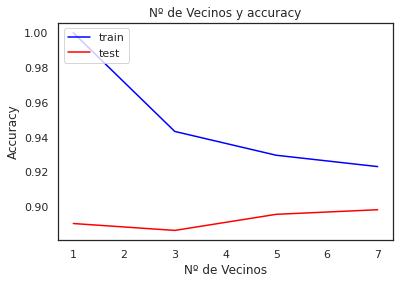

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# entrenamos para diferentes números de vecinos
accuracie_train, accuracie_test = [],[]
# Nº de vecinos
neighbors = list(range(1,8,2)) # numeros impares de vecinos
for n_neighbor in neighbors:
  # train
  knn = KNeighborsClassifier(n_neighbors=n_neighbor).fit(X_train, y_train)
  # predict y guardar accuracy
  accuracie_train.append(accuracy_score(y_train, knn.predict(X_train)))
  accuracie_test.append(accuracy_score(y_test, knn.predict(X_test)))

# plot
plt.plot(neighbors,accuracie_train, color='blue')
plt.plot(neighbors,accuracie_test, color='red')
plt.title('Nº de Vecinos y accuracy')
plt.xlabel('Nº de Vecinos')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

**OBS:** se observa N° Vecinos y Acurracy, con N = 7, las líneas de train y test obtienen su menor distancia.

## 7.2 TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
TREE = DecisionTreeClassifier(random_state=0, max_depth = 2).fit(X_train,y_train)
# accuracy
print(f"Accuracy train: {accuracy_score(y_train, TREE.predict(X_train))}")
print(f"Accuracy test : {accuracy_score(y_test, TREE.predict(X_test))}")

Accuracy train: 0.8326822916666666
Accuracy test : 0.8087071240105541


[Text(697.5, 453.0, 'COD_OFI_FUGA_SI <= 0.5\ngini = 0.5\nsamples = 1536\nvalue = [779, 757]\nclass = SI'),
 Text(348.75, 271.8, 'RM_SI <= 0.5\ngini = 0.32\nsamples = 839\nvalue = [671, 168]\nclass = SI'),
 Text(174.375, 90.59999999999997, 'gini = 0.005\nsamples = 367\nvalue = [366, 1]\nclass = SI'),
 Text(523.125, 90.59999999999997, 'gini = 0.457\nsamples = 472\nvalue = [305, 167]\nclass = SI'),
 Text(1046.25, 271.8, 'LOG_EDAD <= 0.367\ngini = 0.262\nsamples = 697\nvalue = [108, 589]\nclass = NO'),
 Text(871.875, 90.59999999999997, 'gini = 0.475\nsamples = 85\nvalue = [52, 33]\nclass = SI'),
 Text(1220.625, 90.59999999999997, 'gini = 0.166\nsamples = 612\nvalue = [56, 556]\nclass = NO')]

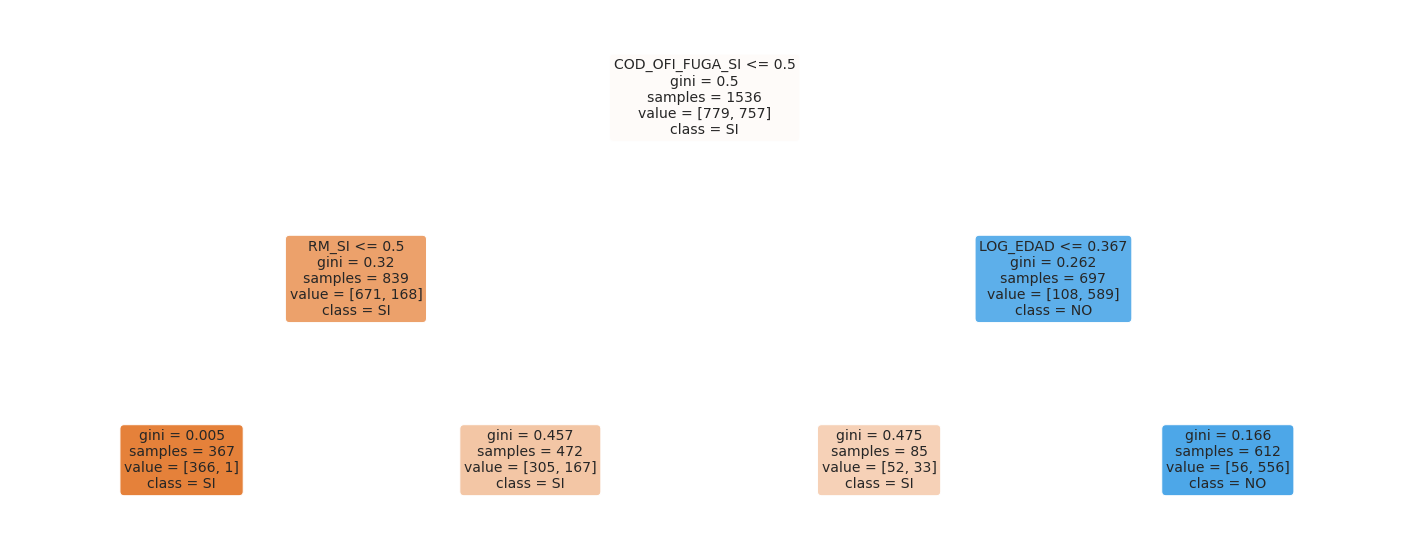

In [ ]:
from sklearn import tree
plt.figure(figsize=(25,10))
tree.plot_tree(TREE,feature_names = X_test.columns, class_names = list(set(y_test)),
               filled = True, rounded=True, fontsize=14)

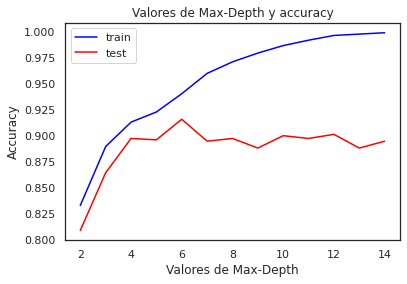

In [ ]:
# entrena para diferentes max-depths
accuracie_train, accuracie_test = [],[]
# valores para C
depths = list(range(2,15))
for depth in depths:
  # train
  TREE = DecisionTreeClassifier(random_state=0, max_depth = depth).fit(X_train,y_train)
  # predict y guardar accuracy
  accuracie_train.append(accuracy_score(y_train, TREE.predict(X_train)))
  accuracie_test.append(accuracy_score(y_test, TREE.predict(X_test)))

# plot
plt.plot(depths,accuracie_train, color='blue')
plt.plot(depths,accuracie_test, color='red')
plt.title('Valores de Max-Depth y accuracy')
plt.xlabel('Valores de Max-Depth')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

## 7.3 SVM

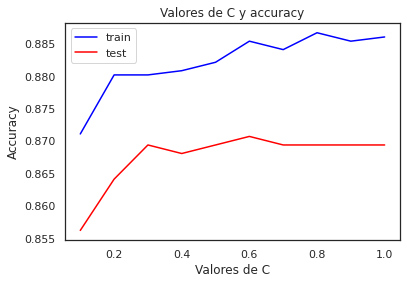

In [ ]:
from sklearn.svm import SVC
# train for diferent number of C
accuracie_train, accuracie_test = [],[]
# valores para C
C = np.linspace(0.1,1,10)
for c in C:
  # train
  SVM = SVC(random_state=0, C=c, kernel='linear').fit(X_train,y_train)
  # predict y guardar accuracy
  accuracie_train.append(accuracy_score(y_train, SVM.predict(X_train)))
  accuracie_test.append(accuracy_score(y_test, SVM.predict(X_test)))

# plot
plt.plot(C,accuracie_train, color='blue')
plt.plot(C,accuracie_test, color='red')
plt.title('Valores de C y accuracy')
plt.xlabel('Valores de C')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

## 7.4 RF

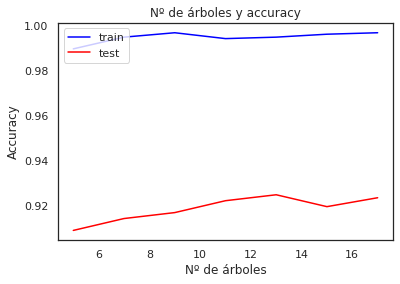

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# train for diferent number of trees
accuracie_train, accuracie_test = [],[]
# numero de árboles 
n_estimators = list(range(5,19,2))
for n_estimator in n_estimators:
  # train
  RF = RandomForestClassifier(n_estimators=n_estimator, random_state=0, n_jobs=-1).fit(X_train,y_train)
  # predict y guardar accuracy
  accuracie_train.append(accuracy_score(y_train, RF.predict(X_train)))
  accuracie_test.append(accuracy_score(y_test, RF.predict(X_test)))

# plot
plt.plot(n_estimators,accuracie_train, color='blue')
plt.plot(n_estimators,accuracie_test, color='red')
plt.title('Nº de árboles y accuracy')
plt.xlabel('Nº de árboles')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

# 8 - Evaluación 

## 8.1 Probabilidad en predict

### 8.1.1 KNN

Accuracy  : 0.943359375
Recall    : 0.9435995747011632
Precision : 0.9437011506730352


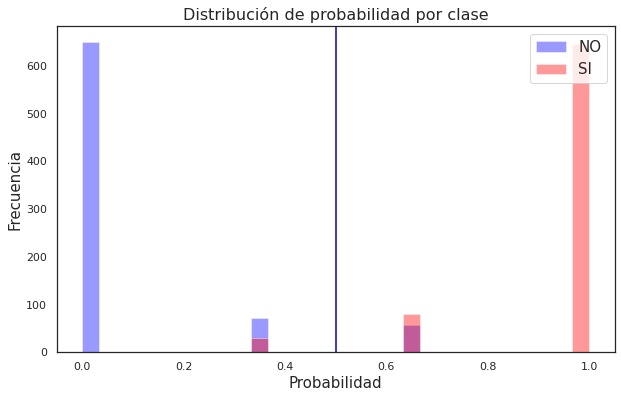

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_prob = KNN.predict_proba(X_train)
y_prob = pd.DataFrame(y_prob, columns=['NO','SI'])   
y_prob['Real'] = y_train.values
#y_prob.head()  

threshold = 0.5
y_pred = ['SI' if prob > threshold else 'NO' for prob in y_prob.SI]

plt.figure(figsize=(10, 6))
sns.distplot(y_prob[y_prob['Real']=="NO"]['SI'], kde=False, label='NO', color="b", bins=20)
sns.distplot(y_prob[y_prob['Real']=="SI"]['SI'], kde=False, label='SI', color="r", bins=20)
plt.axvline(x=threshold)
plt.legend(prop={'size': 15})
plt.title('Distribución de probabilidad por clase', fontsize=16)
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)

# print metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy  : {accuracy_score(y_train, y_pred)}")
print(f"Recall    : {recall_score(y_train, y_pred, average='macro')}")
print(f"Precision : {precision_score(y_train, y_pred, average='macro')}")

### 8.1.2 TREE

Accuracy  : 0.9401041666666666
Recall    : 0.9404089855401787
Precision : 0.9407139039021204


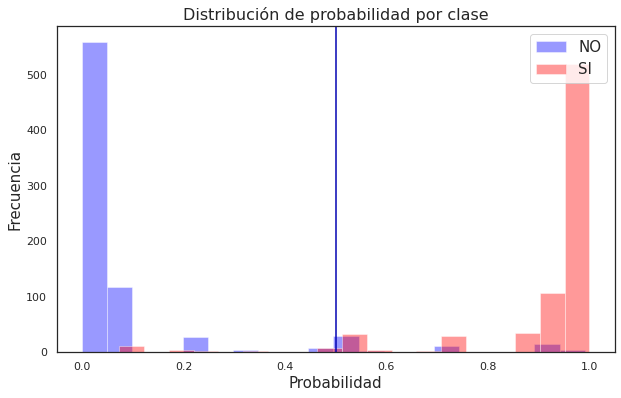

In [ ]:
TREE = DecisionTreeClassifier(random_state=0, max_depth = 6).fit(X_train,y_train)
y_prob = TREE.predict_proba(X_train)
y_prob = pd.DataFrame(y_prob, columns=['NO','SI'])   
y_prob['Real'] = y_train.values
#y_prob.head()  

threshold = 0.5
y_pred = ['SI' if prob > threshold else 'NO' for prob in y_prob.SI]
#y_pred[0:10]

plt.figure(figsize=(10, 6))
sns.distplot(y_prob[y_prob['Real']=="NO"]['SI'], kde=False, label='NO', color="b", bins=20)
sns.distplot(y_prob[y_prob['Real']=="SI"]['SI'], kde=False, label='SI', color="r", bins=20)
plt.axvline(x=threshold)
plt.legend(prop={'size': 15})
plt.title('Distribución de probabilidad por clase', fontsize=16)
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)

# print metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy  : {accuracy_score(y_train, y_pred)}")
print(f"Recall    : {recall_score(y_train, y_pred, average='macro')}")
print(f"Precision : {precision_score(y_train, y_pred, average='macro')}")

### 8.1.3 SVM

Accuracy  : 0.91015625
Recall    : 0.9101378151374506
Precision : 0.9101378151374506


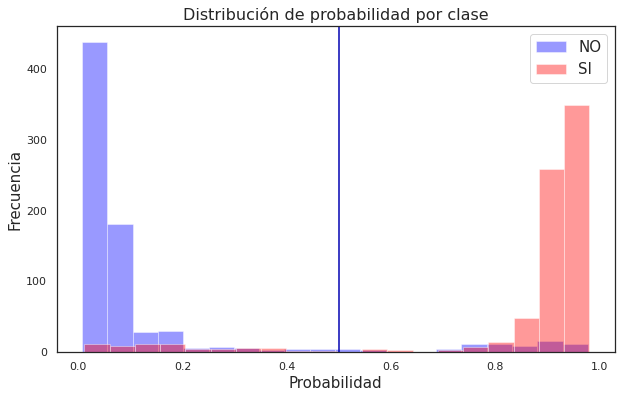

In [ ]:
from sklearn.metrics import roc_curve
# entrenamos con el mejor valor de C
SVM = SVC(random_state=0, C=0.3, probability=True).fit(X_train,y_train)

# predict probabilities
y_prob = SVM.predict_proba(X_train)
y_prob = pd.DataFrame(y_prob, columns=['NO','SI'])   
y_prob['Real'] = y_train.values
#y_prob.head()  

threshold = 0.5
y_pred = ['SI' if prob > threshold else 'NO' for prob in y_prob.SI]
#y_pred[0:10]

plt.figure(figsize=(10, 6))
sns.distplot(y_prob[y_prob['Real']=="NO"]['SI'], kde=False, label='NO', color="b", bins=20)
sns.distplot(y_prob[y_prob['Real']=="SI"]['SI'], kde=False, label='SI', color="r", bins=20)
plt.axvline(x=threshold)
plt.legend(prop={'size': 15})
plt.title('Distribución de probabilidad por clase', fontsize=16)
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)

# print metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy  : {accuracy_score(y_train, y_pred)}")
print(f"Recall    : {recall_score(y_train, y_pred, average='macro')}")
print(f"Precision : {precision_score(y_train, y_pred, average='macro')}")

### 8.1.4 RF

Accuracy  : 0.9947916666666666
Recall    : 0.9947532910634675
Precision : 0.9948405611271389


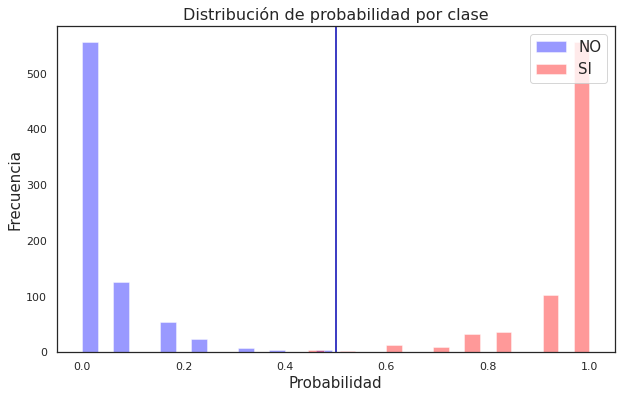

In [ ]:
RF = RandomForestClassifier(n_estimators=13, random_state=0, n_jobs=-1).fit(X_train,y_train)
y_prob = RF.predict_proba(X_train)
y_prob = pd.DataFrame(y_prob, columns=['NO','SI'])   
y_prob['Real'] = y_train.values
#y_prob.head()  

threshold = 0.5
y_pred = ['SI' if prob > threshold else 'NO' for prob in y_prob.SI]

plt.figure(figsize=(10, 6))
sns.distplot(y_prob[y_prob['Real']=="NO"]['SI'], kde=False, label='NO', color="b", bins=20)
sns.distplot(y_prob[y_prob['Real']=="SI"]['SI'], kde=False, label='SI', color="r", bins=20)
plt.axvline(x=threshold)
plt.legend(prop={'size': 15})
plt.title('Distribución de probabilidad por clase', fontsize=16)
plt.xlabel('Probabilidad', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)

# print metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy  : {accuracy_score(y_train, y_pred)}")
print(f"Recall    : {recall_score(y_train, y_pred, average='macro')}")
print(f"Precision : {precision_score(y_train, y_pred, average='macro')}")

## 8.2 Plot ROC

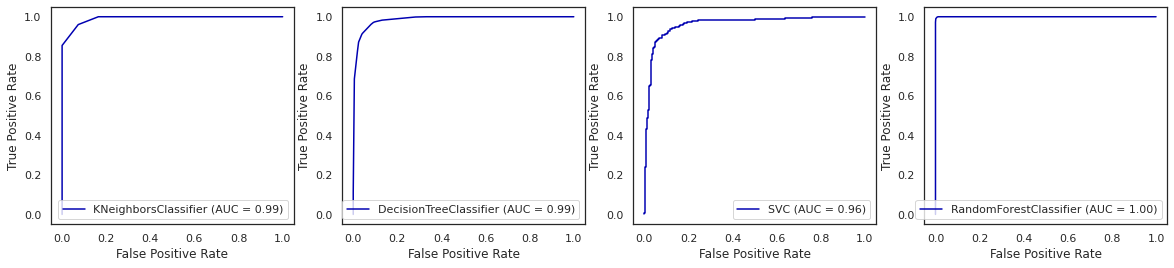

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4))
metrics.plot_roc_curve(KNN, X_train, y_train,ax=axes[0])
metrics.plot_roc_curve(TREE, X_train, y_train,ax=axes[1])
metrics.plot_roc_curve(SVM, X_train, y_train,ax=axes[2])
metrics.plot_roc_curve(RF, X_train, y_train,ax=axes[3])

## 8.3 Validación cruzada

In [ ]:
# diccionario con modelos a evaluar (Clasificación)
models = {"RF":RandomForestClassifier(n_estimators=13, random_state=0),"KNN":KNeighborsClassifier(n_neighbors=3),
          "TREE":DecisionTreeClassifier(random_state=0, max_depth = 6), "SVM":SVC(random_state=0, C=0.3, kernel='linear')}
entries = []
# iteramos sobre los modelos. Entrenamos y evaluamos
for name,model in models.items():
  print(f"Train {name}")
  Accuracies = cross_val_score(model, X_train, y_train, scoring ='accuracy', cv=10, n_jobs =-1)
  for fold_idx, accuracy in enumerate(Accuracies):
      entries.append((name, fold_idx, accuracy))
      cv_results = pd.DataFrame(entries, columns=['Model', 'fold', 'Accuracy'])

Train RF
Train KNN
Train TREE
Train SVM


In [ ]:
# como resultado de la validación cruzada, tenemos un df con la información del accuracy del modelo en cada "carpeta" del conjunto de training
cv_results

,Model,fold,Accuracy
0,RF,0,0.922078
1,RF,1,0.928571
2,RF,2,0.948052
3,RF,3,0.915584
4,RF,4,0.889610
5,RF,5,0.922078
6,RF,6,0.901961
7,RF,7,0.941176
8,RF,8,0.954248
9,RF,9,0.954248


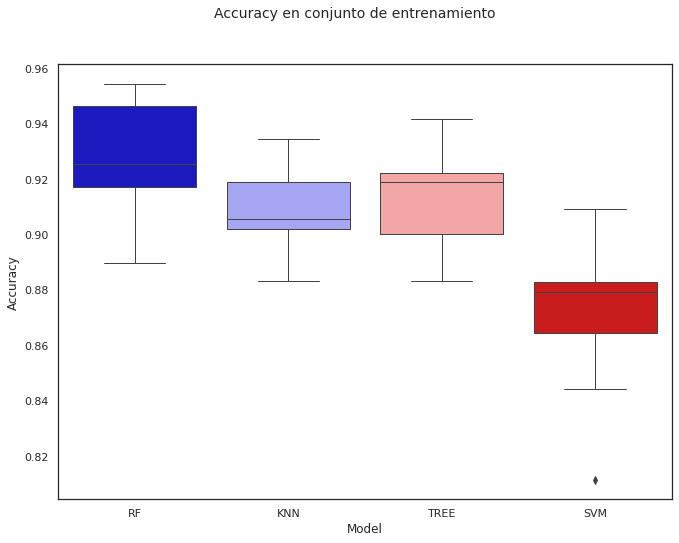

In [ ]:
# plot the results of each model on a single box plot    
plt.figure(figsize=(11, 8))
plt.suptitle("Accuracy en conjunto de entrenamiento", fontsize=14)
sns.boxplot(x='Model', y='Accuracy', data=cv_results, palette='seismic', linewidth=1) 

In [ ]:
cv_results.groupby('Model')['Accuracy'].agg(['mean','std']).reset_index()

,Model,mean,std
0,KNN,0.907555,0.015581
1,RF,0.927761,0.021933
2,SVM,0.873075,0.028978
3,TREE,0.913394,0.018510


## 8.4 Matriz de beneficio/costo

In [ ]:
#Definición de función para realizar matriz de confusión.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    fig = plt.figure(figsize=(8,8))
    plt.title(title, figure=fig)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, figure=fig)
    plt.yticks(tick_marks, classes, figure=fig)

    # normalized confusion matrix
    ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = 0.5
    for i, j in itertools.product(range(ncm.shape[0]), range(ncm.shape[1])):
        plt.text(j, i, str(round(100*ncm[i, j],2))+"%",
                 horizontalalignment="center",
                 color="white" if ncm[i, j] > thresh else "black",
                 fontsize=12, figure=fig)
        plt.text(j, i+0.1, str(cm[i, j]),
                 horizontalalignment="center",
                 color="black",
                 fontsize=10, figure=fig)

    plt.imshow(ncm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1, figure=fig)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label',figure=fig)
    plt.xlabel('Predicted label',figure=fig)
    plt.close(fig)
    return fig

def get_cm(true_labels, predicted_labels):
    #get confusion matrix
    labels = np.unique(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    #get plot of confusion matrix
    plot = plot_confusion_matrix(cm, labels)
    return plot

### 8.4.1 Matriz KNN

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = knn
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(set(y_train))))

              precision    recall  f1-score   support

          SI       0.93      0.86      0.89       378
          NO       0.87      0.93      0.90       380

    accuracy                           0.90       758
   macro avg       0.90      0.90      0.90       758
weighted avg       0.90      0.90      0.90       758



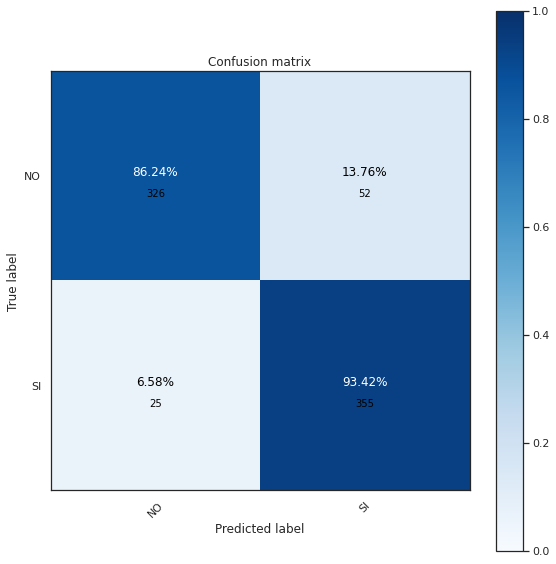

In [ ]:
get_cm(y_test, y_pred)

In [ ]:
#Cálculo de beneficio o costo para la empresa en caso de elegir este metodo
beneficio_knn = 355*1000+25*-5000+52*-100
#inf der, inf izq, sup der
beneficio_knn

224800

### 8.4.2 Matriz TREE

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = TREE
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(set(y_train))))

# macro: promedio simple de la medida. Ej macr_avg(0.79, 0.81) = 0.8
# weighted: promedia las medidas ponderadas por el soporte de cada clase

              precision    recall  f1-score   support

          SI       0.93      0.90      0.91       378
          NO       0.90      0.93      0.92       380

    accuracy                           0.92       758
   macro avg       0.92      0.92      0.92       758
weighted avg       0.92      0.92      0.92       758



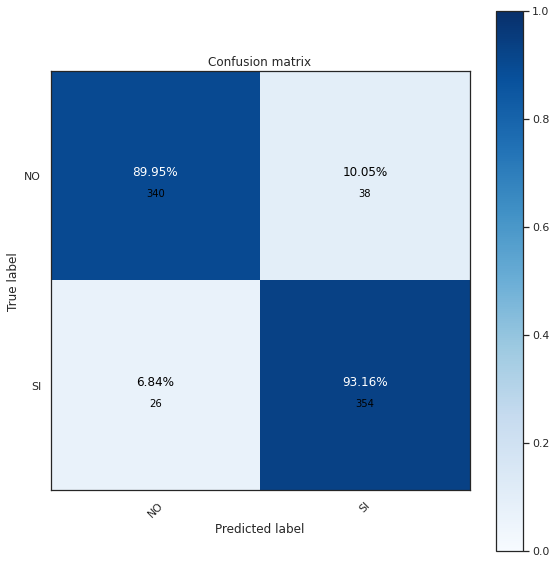

In [ ]:
get_cm(y_test, y_pred)

In [ ]:
#Cálculo de beneficio o costo para la empresa en caso de elegir este metodo
beneficio_tree = 354*1000+26*-5000+38*-100
#inf der, inf izq, sup der
beneficio_tree

220200

### 8.4.3 Matriz SVM

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = SVM
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(set(y_train))))

# macro: promedio simple de la medida. Ej macr_avg(0.79, 0.81) = 0.8
# weighted: promedia las medidas ponderadas por el soporte de cada clase

              precision    recall  f1-score   support

          SI       0.88      0.87      0.87       378
          NO       0.87      0.88      0.87       380

    accuracy                           0.87       758
   macro avg       0.87      0.87      0.87       758
weighted avg       0.87      0.87      0.87       758



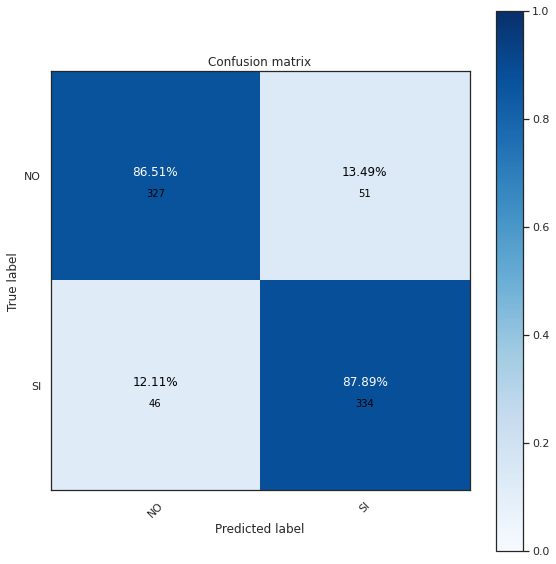

In [ ]:
get_cm(y_test, y_pred)

In [ ]:
#Cálculo de beneficio o costo para la empresa en caso de elegir este metodo
beneficio_svm = 334*1000+46*-5000+51*-100
#inf der, inf izq, sup der
beneficio_svm

98900

### 8.4.4 Matriz RF

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = RF
y_pred = RF.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(set(y_train))))

              precision    recall  f1-score   support

          SI       0.92      0.93      0.92       378
          NO       0.93      0.92      0.92       380

    accuracy                           0.92       758
   macro avg       0.92      0.92      0.92       758
weighted avg       0.92      0.92      0.92       758



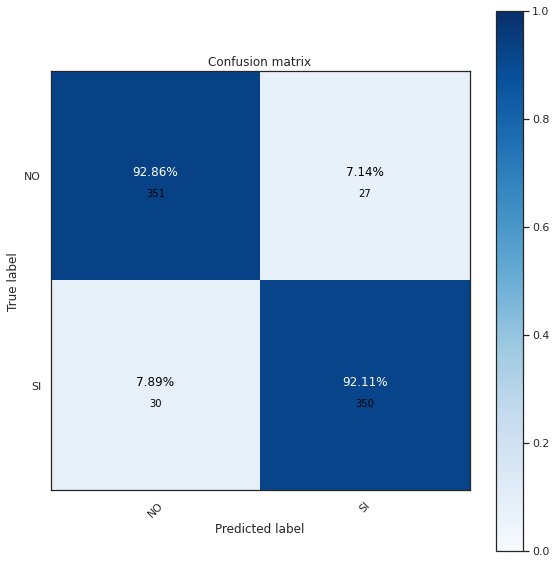

In [ ]:
get_cm(y_test, y_pred)

In [ ]:
#Cálculo de beneficio o costo para la empresa en caso de elegir este metodo
beneficio_rf = 350*1000+30*-5000+27*-100
#inf der, inf izq, sup der
beneficio_rf

197300

**OBS:** El mayor beneficio se obtiene al utilizar el modelo KNN >> 
224800 KNN, 220200 THREE, 197300 RF, 98900 SVM

# 9 Procesamiento datos de validación

In [ ]:
#df_validacion.isna().sum()

#Creación de variables
df_validacion["D_Marzo_X"]= df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Marzo"] > 0 else 0, axis=1)
df_validacion["D_Abril_X"]= df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Abril"] > 0 else 0, axis=1)
df_validacion["D_Mayo_X"]= df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Mayo"] > 0 else 0, axis=1)
df_validacion["D_Junio_X"]= df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Junio"] > 0 else 0, axis=1)
df_validacion["D_Julio_X"]= df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Julio"] > 0 else 0, axis=1)
df_validacion["D_Agosto_X"]= df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Agosto"] > 0 else 0, axis=1)
df_validacion["D_Septiembre_X"]=df_validacion.apply(lambda df_validacion: 1 if df_validacion["D_Septiembre"] > 0 else 0, axis=1)
df_validacion["DEUDA_MESES"]=df_validacion["D_Marzo_X"]+df_validacion["D_Abril_X"]+df_validacion["D_Mayo_X"]+df_validacion["D_Junio_X"]+df_validacion["D_Julio_X"]+df_validacion["D_Julio_X"]+df_validacion["D_Agosto_X"]+df_validacion["D_Septiembre_X"]
df_validacion["DEUDA_TOTAL"]= df_validacion["D_Marzo"] + df_validacion["D_Abril"] + df_validacion["D_Mayo"]+df_validacion["D_Junio"]+df_validacion["D_Julio"]+df_validacion["D_Agosto"]+df_validacion["D_Septiembre"]

#Agrupación
##REGION_METROPOLITANA
df_validacion['REGION_METROPOLITANA'] = df_validacion['CIUDAD'].apply(lambda x: 'SI' if x=='SANTIAGO' else 'NO')
##COD_OFI_2
df_validacion = pd.merge(df_validacion, tabla_contingencia, left_on=['COD_OFI'], right_on=['COD_OFI'], how='left')
##COD_COM_2
df_validacion = pd.merge(df_validacion, tabla_contingencia2, left_on=['COD_COM'], right_on=['COD_COM'], how='left')
##NIV_EDUC_2
df_validacion["NIV_EDUC_2"] = df_validacion.apply(lambda df_validacion: 'MED'  if df_validacion["NIV_EDUC"] == 'BAS' else df_validacion["NIV_EDUC"], axis=1)
df_validacion["NIV_EDUC_2"] = df_validacion.apply(lambda df_validacion: 'UNV'  if df_validacion["NIV_EDUC_2"] == 'EUN' else df_validacion["NIV_EDUC_2"], axis=1)

#Eliminación de atributos
df_validacion.drop(['COD_OFI','COD_COM','CIUDAD','D_Marzo','D_Abril','D_Mayo','D_Junio','D_Julio','D_Agosto','D_Septiembre','NIV_EDUC','D_Marzo_X','D_Abril_X','D_Mayo_X','D_Junio_X','D_Julio_X','D_Agosto_X','D_Septiembre_X'], axis='columns', inplace=True)

#Declaración de valores perdidos o inconsistentes
df_validacion.loc[df_validacion['EDAD'] < 18, 'EDAD'] = np.nan
df_validacion.loc[df_validacion['EDAD'] > 100, 'EDAD'] = np.nan

#Imputación de valores perdidos
df_validacion['GENERO'].fillna(df_validacion['GENERO'].mode()[0], inplace=True)
df_validacion['NIV_EDUC_2'].fillna(df_validacion['NIV_EDUC_2'].mode()[0], inplace=True)
df_validacion['E_CIVIL'].fillna(df_validacion['E_CIVIL'].mode()[0], inplace=True)
df_validacion['COD_COM_2'].fillna(df_validacion['COD_COM_2'].mode()[0], inplace=True)
df_validacion['EDAD'].fillna(np.nanmedian(df_validacion['EDAD']), inplace=True)
df_validacion['M_MOROSO'].fillna(np.nanmedian(df_validacion['EDAD']), inplace=True)
df_validacion['SEGURO'].fillna(df_validacion['SEGURO'].mode()[0], inplace=True)
df_validacion['COD_OFI_2'].fillna(df_validacion['COD_OFI_2'].mode()[0], inplace=True)

#Transformación con logaritmo
df_validacion['LOG_RENTA'] = np.log(df_validacion['RENTA']+1) 
df_validacion['LOG_EDAD'] = np.log(df_validacion['EDAD']+1) 
df_validacion['LOG_M_MOROSO'] = np.log(df_validacion['M_MOROSO']+1)
df_validacion['LOG_MONTO'] = np.log(df_validacion['MONTO']+1)
df_validacion['LOG_DEUDA_TOTAL'] = np.log(df_validacion['DEUDA_TOTAL']+1)
df_validacion['LOG_DEUDA_MESES'] = np.log(df_validacion['DEUDA_MESES']+1)

#df_validacion.drop(['RENTA','EDAD','M_MOROSO','MONTO','DEUDA_TOTAL','DEUDA_MESES'], inplace=True, axis='columns')

#Transformación de variables categóricas
df_validacion.replace({'GENERO':{'F':'GENERO_F','M':'GENERO_M'}}, inplace=True)
df_validacion.replace({'SEGURO':{'SI':'SEGURO_SI','NO':'SEGURO_NO'}}, inplace=True)
df_validacion.replace({'REGION_METROPOLITANA':{'SI':'RM_SI','NO':'RM_NO'}}, inplace=True)
df_validacion.replace({'NIV_EDUC_2':{'MED':1,'TEC':2,'UNV':3}}, inplace=True)
df_validacion.replace({'E_CIVIL':{'SOL':0,'CAS':1,'SEP':2,'VIU':3}},inplace=True)
df_validacion.replace({'COD_OFI_2':{'SI':'COD_OFI_FUGA_SI','NO':'COD_OFI_FUGA_NO'}}, inplace=True)
df_validacion.replace({'COD_COM_2':{'SI':'COD_COM_FUGA_SI','NO':'COD_COM_FUGA_NO'}}, inplace=True)

df_validacion = pd.concat([df_validacion, pd.get_dummies(df_validacion['GENERO'])], axis='columns')
df_validacion = pd.concat([df_validacion, pd.get_dummies(df_validacion['SEGURO'])], axis='columns')
df_validacion = pd.concat([df_validacion, pd.get_dummies(df_validacion['REGION_METROPOLITANA'])], axis='columns')
df_validacion = pd.concat([df_validacion, pd.get_dummies(df_validacion['COD_COM_2'])], axis='columns')
df_validacion = pd.concat([df_validacion, pd.get_dummies(df_validacion['COD_OFI_2'])], axis='columns')

# se elimina variable original y redundantes
df_validacion.drop(['GENERO','GENERO_F','SEGURO','SEGURO_NO','REGION_METROPOLITANA','RM_NO','COD_OFI_2','COD_OFI_FUGA_NO','COD_COM_2','COD_COM_FUGA_NO','ID','LOG_RENTA','E_CIVIL','LOG_DEUDA_MESES','FUGA','COD_COM_FUGA_SI','RENTA','EDAD','M_MOROSO','MONTO','DEUDA_TOTAL','DEUDA_MESES'], inplace=True, axis='columns')

#Escalamiento
scaler = MinMaxScaler()
#df_validacion[['LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL']] = scaler.fit_transform(df_validacion[['LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL']])
df_validacion[['LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL','NIV_EDUC_2']] = scaler.fit_transform(df_validacion[['LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL','NIV_EDUC_2']])

df_validacion.isna().sum()

NIV_EDUC_2         0
LOG_EDAD           0
LOG_M_MOROSO       0
LOG_MONTO          0
LOG_DEUDA_TOTAL    0
GENERO_M           0
SEGURO_SI          0
RM_SI              0
COD_OFI_FUGA_SI    0
dtype: int64

In [ ]:
df_validacion

,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI
0,1.0,0.680853,0.182088,0.608240,0.754781,1,0,1,1
1,0.5,0.316561,0.000000,0.481500,0.662689,0,0,0,0
2,1.0,0.794024,0.182088,0.284376,0.847694,1,1,0,1
3,0.0,0.596880,0.364176,0.701839,0.793558,0,0,1,1
4,0.0,0.618601,0.182088,0.500000,0.786228,1,0,1,0
...,...,...,...,...,...,...,...,...,...
1195,1.0,0.757820,0.288602,0.565758,0.835388,0,0,1,1
1196,1.0,0.739172,0.182088,0.500000,0.457228,0,1,0,1
1197,0.5,0.596880,0.182088,0.461999,0.788552,0,1,1,0
1198,0.5,0.528474,0.182088,0.721881,0.628730,0,0,1,0


# 10 Predicción con datos de validación

In [ ]:
y_pred = KNN.predict(df_validacion)
df_validacion['FUGA']=y_pred
df_validacion.head()

,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI,FUGA
0,1.0,0.680853,0.182088,0.608240,0.754781,1,0,1,1,SI
1,0.5,0.316561,0.000000,0.481500,0.662689,0,0,0,0,NO
2,1.0,0.794024,0.182088,0.284376,0.847694,1,1,0,1,SI
3,0.0,0.596880,0.364176,0.701839,0.793558,0,0,1,1,NO
4,0.0,0.618601,0.182088,0.500000,0.786228,1,0,1,0,SI


In [ ]:
df_validacion.to_csv("BASEFUGA_VALIDACION_PREDICT")

In [ ]:
collections.Counter(y_pred) 

Counter({'NO': 563, 'SI': 637})

**OBS:** 
A pesar del beneficio obtenido con el modelo KNN, se escoge RF para realizar la predicción, ya que tiene mejores indicadores de precision, recall, f1-score y support.
De los 1200 datos a predecir, se puede observar 
que el 31,2% de los registros que indica se fugarán. De esta manera, se deberán buscar políticas comerciales para retener a esos clientes.

# 11 Clusterización de datos 



Dado que existen atributos tanto categóricos como numéricos en el presente dataset se hace necesario ocupar técnicas de clustering que nos permita trabajar de manera conjunta para ambos casos, es por lo anterior que elegimos k-prototype 
https://link.springer.com/article/10.1023/A:1009769707641


Desde el dataset validación se realizan las respectivas transformaciones, escalamiento y preprocesamiento filtrando solamente a los clientes en fuga

## 11.1 Procesamiento para cluster

In [ ]:
#Solo deben quedar en el dataframe solo los casos que se fugarán.
df_val_nofugados = df_validacion.copy()
df_val_nofugados = df_val_nofugados.drop(df_val_nofugados[df_val_nofugados['FUGA']=='SI'].index)

df_validacion = df_validacion.drop(df_validacion[df_validacion['FUGA']=='NO'].index)
df_validacion.head()

,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI,FUGA
0,1.0,0.680853,0.182088,0.608240,0.754781,1,0,1,1,SI
2,1.0,0.794024,0.182088,0.284376,0.847694,1,1,0,1,SI
4,0.0,0.618601,0.182088,0.500000,0.786228,1,0,1,0,SI
7,0.5,0.680853,0.182088,0.731500,0.762409,1,1,0,1,SI
8,1.0,0.574637,0.288602,0.461999,0.789559,0,0,0,0,SI


Se verifica que el df no posea datos faltantes debido a el error que pudiese conllevar en el posterior algoritmo

## 11.2 k-Prototype 

In [ ]:
print(df_validacion.isna().sum())

NIV_EDUC_2         0
LOG_EDAD           0
LOG_M_MOROSO       0
LOG_MONTO          0
LOG_DEUDA_TOTAL    0
GENERO_M           0
SEGURO_SI          0
RM_SI              0
COD_OFI_FUGA_SI    0
FUGA               0
dtype: int64


In [ ]:
df_validacion

,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI,FUGA
0,1.0,0.680853,0.182088,0.608240,0.754781,1,0,1,1,SI
2,1.0,0.794024,0.182088,0.284376,0.847694,1,1,0,1,SI
4,0.0,0.618601,0.182088,0.500000,0.786228,1,0,1,0,SI
7,0.5,0.680853,0.182088,0.731500,0.762409,1,1,0,1,SI
8,1.0,0.574637,0.288602,0.461999,0.789559,0,0,0,0,SI
...,...,...,...,...,...,...,...,...,...,...
1192,1.0,0.660565,0.182088,0.758906,0.876729,1,0,1,0,SI
1193,1.0,0.639821,0.364176,0.284376,0.747221,1,0,1,1,SI
1195,1.0,0.757820,0.288602,0.565758,0.835388,0,0,1,1,SI
1196,1.0,0.739172,0.182088,0.500000,0.457228,0,1,0,1,SI


In [ ]:
df_validacion.drop('FUGA', axis=1, inplace=True)

**OBS:** Iniciando con el algoritmo k-prototypes se define cuales son las variables categóricas y numéricas y se hacen las respectivas transformaciones a matrices numpy

In [ ]:
dfMatrix = df_validacion.to_numpy()
dfMatrix

array([[1.        , 0.68085335, 0.1820879 , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.79402352, 0.1820879 , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.61860052, 0.1820879 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.75782017, 0.28860249, ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.73917171, 0.1820879 , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 0.68085335, 0.28860249, ..., 0.        , 1.        ,
        1.        ]])

**OBS:** En cuanto a la elección del número de clúster con el cual trabajar nos decantamos por el método del codo. Al no poseer información sobre alguna regla de negocio que nos permita entender la cantidad de segmentos que se hace posible atender simultánemente por parte del banco el presente método estadístico es de gran ayuda.

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8


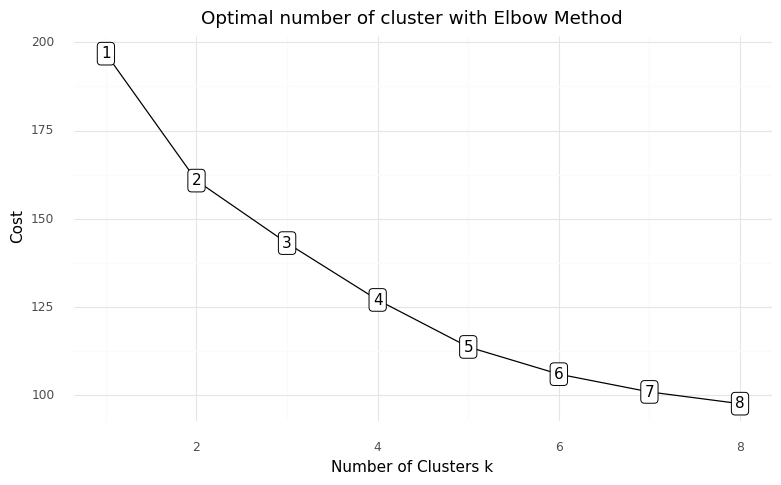

<ggplot: (8755807400397)>

In [ ]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1,9):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = [0,5,6,7,8])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1,9), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (9,5)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster')) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

**OBS:** Tal como se observa la pendiente en el 2do clúster decae rápidamente aunque esta no deja de caer hasat el 3ero donde se comienza a estabilizar. En base a lo anterior se segmentará la presente información en tres tipos de clientes.

Ya configurada la cantidad de segmentos a utilizar se procede a ajustar y echar a andar el modelo

In [ ]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = [0,5,6,7,8])

array([0, 0, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 0, 2, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 2,
       2, 2, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 1, 0,
       1, 1, 0, 2, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 0,
       2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0,
       1, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0,
       2, 1, 0, 2, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0,
       1, 0, 0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2, 1, 0,
       2, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1,
       0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 2,
       0, 1, 2, 2, 0, 2, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 2, 1,
       0, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 1,

In [ ]:
# Cluster centorid
kprototype.cluster_centroids_
# Check the iteration of the clusters created
kprototype.n_iter_
# Check the cost of the clusters created
kprototype.cost_

143.12003263761787

In [ ]:
# Add the cluster to the dataframe
df_validacion['Cluster Labels'] = kprototype.labels_
df_validacion['Segment'] = df_validacion['Cluster Labels'].map({0:'UNO', 1:'DOS', 2:'TRES'})
# Order the cluster
df_validacion['Segment'] = df_validacion['Segment'].astype('category')

In [ ]:
df_validacion

,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI,Cluster Labels,Segment
0,1.0,0.680853,0.182088,0.608240,0.754781,1,0,1,1,0,UNO
2,1.0,0.794024,0.182088,0.284376,0.847694,1,1,0,1,0,UNO
4,0.0,0.618601,0.182088,0.500000,0.786228,1,0,1,0,2,TRES
7,0.5,0.680853,0.182088,0.731500,0.762409,1,1,0,1,1,DOS
8,1.0,0.574637,0.288602,0.461999,0.789559,0,0,0,0,2,TRES
...,...,...,...,...,...,...,...,...,...,...,...
1192,1.0,0.660565,0.182088,0.758906,0.876729,1,0,1,0,2,TRES
1193,1.0,0.639821,0.364176,0.284376,0.747221,1,0,1,1,0,UNO
1195,1.0,0.757820,0.288602,0.565758,0.835388,0,0,1,1,0,UNO
1196,1.0,0.739172,0.182088,0.500000,0.457228,0,1,0,1,0,UNO


**OBS:** Se calculan los centroides mediante la moda y el promedio de las variables categóricas y numéricas respectivamente

In [ ]:
# Cluster interpretation
df_validacion.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_validacion.groupby('Segment').agg(
    {
        'Total':'count',
        'GENERO_M': lambda x: x.value_counts().index[0],
        'SEGURO_SI': lambda x: x.value_counts().index[0],
        'RM_SI': lambda x: x.value_counts().index[0],
        'COD_OFI_FUGA_SI': lambda x: x.value_counts().index[0],
        'NIV_EDUC_2': lambda x: x.value_counts().index[0],
        'LOG_EDAD': 'mean',
        'LOG_M_MOROSO': 'mean',
        'LOG_MONTO': 'mean',
        'LOG_DEUDA_TOTAL': 'mean'
    }
).reset_index()

,Segment,Total,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL
0,DOS,206,1,0,1,1,1.0,0.719475,0.213311,0.858285,0.800646
1,TRES,227,1,0,1,0,1.0,0.593144,0.191172,0.573710,0.757232
2,UNO,204,1,0,1,1,1.0,0.696712,0.228421,0.411288,0.758001


In [ ]:
df_validacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NIV_EDUC_2       637 non-null    float64 
 1   LOG_EDAD         637 non-null    float64 
 2   LOG_M_MOROSO     637 non-null    float64 
 3   LOG_MONTO        637 non-null    float64 
 4   LOG_DEUDA_TOTAL  637 non-null    float64 
 5   GENERO_M         637 non-null    uint8   
 6   SEGURO_SI        637 non-null    uint8   
 7   RM_SI            637 non-null    uint8   
 8   COD_OFI_FUGA_SI  637 non-null    uint8   
 9   Total            637 non-null    uint16  
 10  Segment          637 non-null    category
dtypes: category(1), float64(5), uint16(1), uint8(4)
memory usage: 34.3 KB


In [ ]:
df_validacion['Total'].value_counts()

2    227
1    206
0    204
Name: Total, dtype: int64

**OBS:** Se puede observar que en general las tres carteras de clientes están balanceados uno con respecto a otro. No existiendo grandes diferencias entre el total de clientes.

A continuación se realiza una visualización el cual nos permita tener claro la repetición de los datos en cada clúster y en cada atributo permitido de los datos para así obtener una mejor categorización de cada clúster 

In [ ]:
df = px.data.tips()
fig = px.parallel_categories(df_validacion, color="Total", dimensions=['GENERO_M','SEGURO_SI','RM_SI','COD_OFI_FUGA_SI','NIV_EDUC_2','LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL'] ,color_continuous_scale=px.colors.diverging.Tealrose_r)
fig.show()

**OBS:** Se visualizan las tendencias en los atributos no mostrados anteriormente lo que nos permite entender la concentración de datos en los distintas columnas del dataset y así obtener una mejor caracterización.

In [ ]:
df_validacion.Total=df_validacion.Total.astype(float)

In [ ]:
fig = px.parallel_coordinates(df_validacion,color="Total",
                               color_continuous_scale=px.colors.diverging.Tealrose_r)
fig.show()

## 11.3 Bautismo del cluster

### 11.3.1 Clúster 0 o Universitarios santiaguinos endeudados

En este segmento la mayoría de los clientes fugados son hombres con educación superior los cuales no poseen ningún tipo de seguro de desgravamen, residentes en la región metropolitana que poseen una alta morosidad y deuda, de mediana edad pero con un alto monto en el crédito preaprobado.

### 11.3.2 Clúster 1 o Jóvenes endeudados de regiones 

A diferencia de la segmentación anterior este clúster, que posee una gran masa de hombres de educación superior y media los cuales no poseen ningún seguro de desgravamen, viven y poseen contacto con el banco en lugares apartados de la región metropolitana. En promedio estos clientes son los de menor rango de edad de todos los segmentos pero aun así poseen la mayor cantidad de meses de mora.

### 11.3.3 Clúster 2 o Mujeres jóvenes y buenas pagadoras

El último clúster está compuesto mayoritariamente por mujeres jóvenes con educación técnica o media las cuales poseen bajos meses de morosidad y viven distribuidamentes tanto en regiones como en Santiago además de tener a su haber contratado una mayor proporción de seguro de degravamen con respecto a las demás categorías.

## 11.4 Perfil de clientes o fugitivos

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8


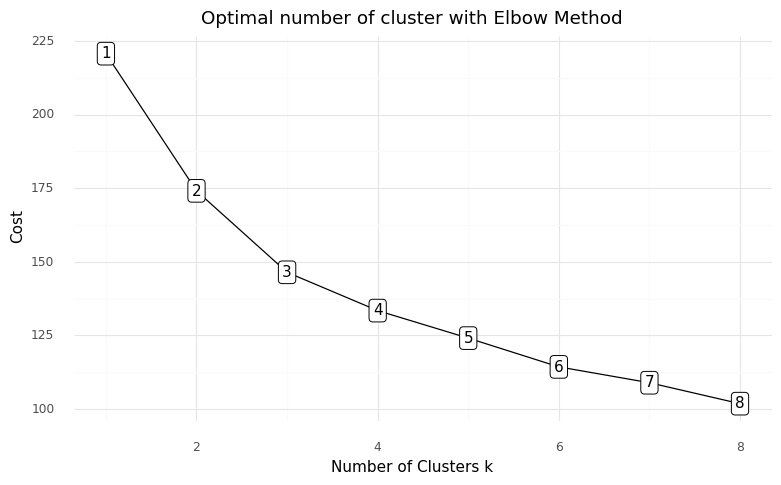

<ggplot: (8755806119385)>

In [ ]:
df_val_nofugados
df_val_nofugados.drop('FUGA', axis=1, inplace=True)
dfMatrix2 = df_val_nofugados.to_numpy()

# Choose optimal K using Elbow method
cost = []
for cluster in range(1,9):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix2, categorical = [0,5,6,7,8])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1,9), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (9,5)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster')) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [ ]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix2, categorical = [0,5,6,7,8])

kprototype.cluster_centroids_
kprototype.n_iter_
kprototype.cost_
# Add the cluster to the dataframe
df_val_nofugados['Cluster Labels'] = kprototype.labels_
df_val_nofugados['Segment'] = df_val_nofugados['Cluster Labels'].map({0:'UNO', 1:'DOS', 2:'TRES'})
# Order the cluster
df_val_nofugados['Segment'] = df_val_nofugados['Segment'].astype('category')
df_val_nofugados.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_val_nofugados.groupby('Segment').agg(
    {
        'Total':'count',
        'GENERO_M': lambda x: x.value_counts().index[0],
        'SEGURO_SI': lambda x: x.value_counts().index[0],
        'RM_SI': lambda x: x.value_counts().index[0],
        'COD_OFI_FUGA_SI': lambda x: x.value_counts().index[0],
        'NIV_EDUC_2': lambda x: x.value_counts().index[0],
        'LOG_EDAD': 'mean',
        'LOG_M_MOROSO': 'mean',
        'LOG_MONTO': 'mean',
        'LOG_DEUDA_TOTAL': 'mean'
    }
).reset_index()

,Segment,Total,GENERO_M,SEGURO_SI,RM_SI,COD_OFI_FUGA_SI,NIV_EDUC_2,LOG_EDAD,LOG_M_MOROSO,LOG_MONTO,LOG_DEUDA_TOTAL
0,DOS,150,1,0,1,1,0.0,0.638021,0.211384,0.569965,0.784739
1,TRES,179,0,0,0,0,0.0,0.693528,0.157444,0.619455,0.748342
2,UNO,234,0,0,1,0,0.5,0.467094,0.178346,0.582846,0.741205


In [ ]:
df = px.data.tips()
fig = px.parallel_categories(df_val_nofugados, color="Total", dimensions=['GENERO_M','SEGURO_SI','RM_SI','COD_OFI_FUGA_SI','NIV_EDUC_2','LOG_EDAD','LOG_M_MOROSO','LOG_MONTO','LOG_DEUDA_TOTAL'] ,color_continuous_scale=px.colors.diverging.Tealrose_r)
fig.show()

**OBS:** En general se observa que los clientes no fugitivos son más jóvenes que los que si se fugan y además una deuda_total menor.
**Cluster uno:** clientes mujeres en su mayoría y sin seguro, perteneciente a la región metropolitana pero en una oficina que no es "crítica" y con nivel educacional medio
**Cluster dos:** Hombres atentidos en una oficina crítica de la región metropolitana, con bajo nivel educacional y alto nivel de endeudamiento
**Cluster tres:** Mujeres de provincia pertenecientes a una oficina "no crítica", con bajo nivel educacional.

# 12 Acciones comerciales generales y específicas para cada segmento

1. ¿Qué hacer para que estos clientes no se fuguen?
2. ¿Cuáles son las acciones comerciales que deberíamos emprender con estos clientes?
3. ¿Se deben aplicar estas medidas a todos los clientes?

A nuestro modo de ver se pueden apreciar características transversales en la presente segmentación de los clientes fugados, algunas de ellas son:
- Falta de cobertura de seguros de desgravamen u de otra índole
- Población jóven en su mayoría con meses de mora que varían segun cohorte
- Mayoría de hombres en la cantidad absoluta de fugas con educación nivel secundario o técnico en su mayoría.

1.- 
- En el primer segmento "Universitarios Santiaguinos endeudados" convendría aplicar medidas de fidelización. Por tener alto nivel de deuda y morosidad es recomendable entregar opciones y herramientas para bajar estos niveles. Para prevenir la fuga, al detectar un cliente con estas carácteristicas se puede ofrecer alternativas de repactación, baja en tasas de interés e incentivos para liquidar las deudas, de lo contratio estas se pueden convertir en deudas incobrables y generar un impacto económico negativo. Fundamental para este proceso es la comunicación con estos clientes, al ser jóvenes tienen una preferencia por lo instantáneo en cuanto a la atención. Para prevenir la insatisfacción en la atención se recomienda potenciar canales digitales de comunicación. Por otra parte complementar la fidelización de este tipo de clientes al ser jovenes se pueden realizar acciones comerciales en base a descuentos, acumulación y canje de puntos, promociones en vida sana, viajes e intereses.


- En el segmento "Jóvenes endeudados de regiones" hay ciertas semejanzas con el segmento anterior, pero es importante enfocar las medidas en la descentralización, la medida principal en este caso sería dar mayor autonomía a ejecutivos en sucursales de regiones, holgura para decisiones comerciales como rebajas de tasas u otros insentivos, esto acortaría los tiempos de repsuesta y disminuye la burocracia que en algunos casos puede ser el determinante en que un cliente se pueda fugar o no. Por otra parte, para la comunciación con estos clientes se podría potenciar mediante redes sociales emergentes tales como TikTok u Instagram además de hacer clips educativos financieros con énfasis en la educación financiera bajando su gran cantidad de morosidad.

- Finalmente el segmento "Mujeres jóvenes y buenas pagadoras", es un segmento que tiene un nivel educacional más bajo que los anteriores y con pocos meses de morosidad. Una buena acción comercial debería tener foco en el emprendimiento femenino, es conocido que las mujeres poseen mejor educación financiera que los hombres mas estas no están insertas del todo en el mundo laboral por lo que generar algún tipo de co work con el banco para lograr prestamos beneficiosos en sus emprendimientos tendría crédito entendiendo el buen apego a las fechas y pago. Por otra parte un buen foco para fidelizar es la capacitación, al ser este segmento de un nivel educacional menor, una buena política sería ofrecer programas que potencien las carreras de este segmento, o bien, becas para especialización técnica.

2.- 
En base a lo anterior existen algunas recomendaciones las cuales debiesen ser aplicadas. Una de ellas es la implementación de algún tipo de vínculo o período de gracia que permita extender el período desde que se detecta un potencial cliente en riego de fugas. Además de lo anterior convendría algún club, puntos y/o descuentos en artículos que se asocien al tipo de clúster anteriormente descrito para de esta forma generar fidelidad en el producto y su cuenta corriente.

La falta de algún tipo de seguro en los clientes en fuga nos indica que fuera de la cuenta corriente y la mora que algunos de ellos poseen con el banco estos no sienten ningún tipo de vínculo que los motive a seguir perteneciendo a la institución mas que la deuda adquirida que en este caso es el mismo motivante de desistimiento a seguir pagando. Crear una estrategia que potencie la adquisición de seguros por parte de los clientes es una buena opción.

Otra recomendación sería dar a conocer a estos clientes cuales son los beneficios de no ser moroso (educación financiera), dado que al ser jovenes pueden obviar las repercusiones de no tener un buen historial financiero. Esto puede resumirse en el acceso a créditos hipotecarios, créditos de consumo y prioridad de servicio para nuevos emprendimientos entre otros. 

Para futuros nuevos clientes también es recomendable, dadas las tendencias, evaluar de mejor manera la capacidad de la linea de crédito que se otorga en primera insancia a los clientes mas jovenes e ir generadto un aumento paulatino del cupo de acuerdo al comportamiento de pago que tengan. Esto sería principalmente premiar a los clientes mas jovenes con un aumento de la linea por su buen comportamiento financiero. Esta medida puede evitar llegar a las deudas incobrables y permite categorizar a los clientes por su comportamiento financiero sin llegar a niveles de deuda extremos.  

Es importante interiorizar la relevancia de trabajar con estos segmentos, ya que los clientes que hoy son categorizados como "jovenes" serán en unos años los clientes "adultos", con mejores salarios y experiencia, pudiendo generar un mejor y mayor impacto económico si se logra un buen nivel de fideliación.

Junto a lo anterior es conveniente generar el potenciamiento de medios digitales de pago junto mediante la App del mismo banco, así como capacitar al cliente y sus ejecutivos en el uso de esta.

3.- En base a lo anterior resulta evidente que ninguna acción comercial sería completa sin una correcta focalización de la misma.

Finalmentes es importante recalcar que para maximizar los beneficios es importante que:
-  Las acciones comerciales se apliquen de la mejor manera posible y en el momento acecuado. 
- Tener en cuenta que el modelo puede ir mejorando según el feedback.
- El personal de la organización debe entender y valorar la toma de decisiones basada en datos. Un equilibrio entre este punto y la expertiz del negocio del personal es lo que puede garantizar la maximización de los beneficios.


